<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Cash Demand Forecasting using Clearscape Analytics
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Introduction</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>    
Predicting future demand for cash in Automatic Teller Machines (ATMs) is crucial for any bank as ATMs are still largely used to dispense cash to customers. ATM cash replenishment is the process of refilling an ATM machine with a specific amount of cash. Due to vacillating users’ demands and seasonal patterns, it is a very challenging problem for financial institutions to keep the optimal amount of cash for each ATM.  <br><br> In this demo, we present a time series model of Teradata Auto Regressive Integrated Moving Average (ARIMA) to solve this problem, perform different exploratory analysis tests, visualizations, diagnostic statistics and more using the In_Db capability of Teradata Vantage.<br>    
We will forecast the amount of required future cash in an ATM by developing a time-series modelling pipeline on cash demand data .The demo shows the power of Vantage through its in-Db analytics time-series capabilities which provide a comprehensive suite of functions most commonly used by Data Scientists across the industry including but not limited to; 
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li><b>Data preparation</b>: Resampling, converting irregular to regular</li>
    <li><b>Data exploration</b>: Detect stationarity and periodicity</li>
    <li><b>Eliminate Non-stationarity</b>: Seasonal normalizing</li>
    <li><b>Formulate candidate models</b>: ARIMA</li>
    <li><b>Goodness of Fit</b>: Parameter estimates, hypothesis statistical tests</li>
    <li><b>Model Validation</b>: Arima Validate</li>
    <li><b>Model Forecasting</b>: Unnormalize, and forecast on test data</li>
    
The implemented function are from the following documentations;
       
- [Teradata Vantage™ - Analytics Database Analytic Functions](https://docs.teradata.com/search/all?query=+Analytics+Database+Analytic+Functions&content-lang=en-US)
- [UAF Time-Series](https://docs.teradata.com/search/all?query=Unbounded+Array+Framework+(UAF)&filters=category~%2522User+Guide%2522&content-lang=en-US)    
    
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Unbounded Array Framework (UAF)</b></p>
    
(UAF) is the Teradata framework for building end-to-end time series forecasting pipelines. It takes the following as inputs.<br>
    
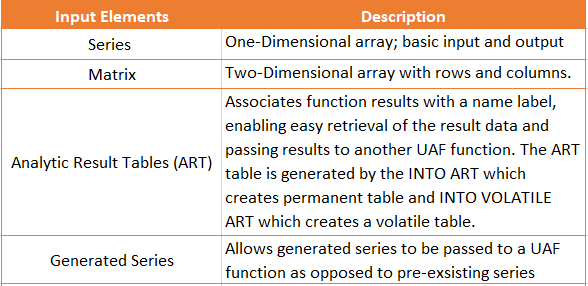


<br> For further information, please [refer here](https://docs.teradata.com/search/all?query=Unbounded+Array+Framework+(UAF)&content-lang=en-US)
    
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Cash Demand Forecasting Demo Data</b></p> 
<b>ATM Dataset</b> : For this notebook we have used anonymised dataset for an ATM from a bank in the UK. The data is composed of daily cash demands for the ATM along with date.

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>1. Connect to Vantage</b></p>

In [1]:
%connect local, hidewarnings=true

Password: ········


Success: 'local' connection established and activated for user 'demo_user', with default database 'demo_user'


In [2]:
Set query_band='DEMO=Cash_Demand_Forecasting_SQL.ipynb;' update for session;

Success: 1 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>You will be prompted to provide the password. Enter your password, press the Enter key, then <b>use down arrow</b> to go to next cell.</p>

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>    
We have provided data for this demo on cloud storage. You have the option of either running the demo using foreign tables to access the data without using any storage on your environment or downloading the data to local storage which may yield somewhat faster execution, but there could be considerations of available storage. There are two statements in the following cell, and one is commented out. You may switch which mode you choose by changing the comment string.

In [3]:
---call get_data('DEMO_UAF_cloud');    -- takes about 20 seconds, estimated space: 0 MB
call get_data('DEMO_UAF_local');     -- takes about 40 seconds, estimated space: 1MB

Success: 0 rows affected

Success: 0 rows affected

Message 1 That ran for 0:00:16.46 with 10 statements and 0 errors.

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Next is an optional step – if you want to see status of databases/tables created and space used.</p>

In [4]:
call space_report();  -- optional, takes about 10 seconds

Success: 0 rows affected

Success: 0 rows affected

Space_Report 1 You have: #databases=2 #tables=1 #views=3 You have used 0.9 MB of 27,890.4 MB available - 0.0% ... Space Usage OK 2 3 Database Name #tables #views Avail MB Used MB 4 demo_user 0 2 27,886.6 MB 0.7 MB 5 DEMO_UAF 0 1 0.0 MB 0.0 MB 6 DEMO_UAF_db 1 0 3.8 MB 0.2 MB

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Printing some sample rows from the dataset</p> 

In [5]:
SELECT TOP 5 * FROM DEMO_UAF.atm_data;

idcol DateTime Amt 1 1 1996-07-04 32.88 2 1 1997-04-10 35.204 3 1 1997-10-22 36.239 4 1 1997-01-05 9.566 5 1 1996-05-21 12.783

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> As we can see from the sample data above there is a date column and demand for ATM's for that day. Let us take one ATM's data and do our analysis on it. 

In [6]:
Select count(*) from DEMO_UAF.atm_data;

Count(*) 1 735

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> We will use these 735 records for further analysis.

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>2. Data Cleaning</b></p>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_GetRowsWithMissingValues</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_GetRowsWithMissingValues</b> displays the rows that have NULL values in the specified input table columns. Please refer <a href ='https://docs.teradata.com/search/all?query=TD_GetRowsWithMissingValues&sort=last_update&content-lang=en-US'>here </a> for more information.
<br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> We have used this function to print if there are any missing rows for our selected target column which is NN5_3. This function would help us identify what is the pattern of missing data (if it exists) and on which time-stamp the data is missing. After this, we can plan accordingly on how to deal with these missing values.</p>

In [7]:
SELECT DateTime,Amt FROM TD_GetRowsWithMissingValues ( 
    ON DEMO_UAF.atm_data
    AS InputTable
    USING
    TargetColumns ('Amt')
) AS dt;

DateTime Amt 1 1998-03-18 2 1997-06-21 3 1996-08-24 4 1997-06-14 5 1996-04-19 6 1996-08-25 7 1996-05-04 8 1996-05-18 9 1997-04-30 10 1996-11-30 11 1997-04-28 12 1997-06-13 13 1996-09-14 14 1996-08-23 15 1996-04-20 16 1997-06-20 17 1996-12-25 18 1997-11-14

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We can confirm the null counts from below.

In [8]:
select count(*) from DEMO_UAF.ATM_Data where Amt is NULL;

Count(*) 1 18

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_OutlierFilterFit</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>Outlier</b>: It’s a data point that is significantly different from other data points in a data set.<br>While this definition might seem straightforward, determining what is or isn’t an outlier is actually pretty subjective, depending on the study and the breadth of information being collected.<br>
    <b>TD_OutlierFilterFit</b> function identifies the values of the upper, and lower bounds and the median value in each column. It is useful because it will help the user to identify in what range the values for a specific column lies. Then these useful insights are used by another function TD_OutlierFilterTransform to highlight the value(s) which is/are significantly high or low from the computed statistics/average value of the column.<br>
    You can use ReplacementValue as <b>'delete' | 'null' | 'median' | replacement_value</b> either of the parameter value to deal with the outliers.<br>Please refer <a href ='https://docs.teradata.com/search/all?query=OutlierFilterFit&sort=last_update&content-lang=en-US'>here </a> for more information.<br><br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> When dealing with time series data we have to identify the outliers and deal with them. When dealing with large datasets we can get the statistics like upper, and lower bounds and the median value in targeted columns in no time using Teradata and its outlierfilterfit function.

In [9]:
CREATE VOLATILE TABLE outlier_fit AS (
    SELECT * FROM TD_OutlierFilterFit (
    ON DEMO_UAF.atm_data AS InputTable
    USING
    TargetColumns ('Amt')
    LowerPercentile (0.05)
    UpperPercentile (0.95)
    OutlierMethod ('percentile')
    ReplacementValue ('delete')
    PercentileMethod ('PercentileCont')
    ) 
    AS dt) 
WITH DATA
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Printing the output of the outlier_fit function

In [10]:
SELECT * FROM  outlier_fit;

TD_OUTLIERMETHOD_OFTFIT TD_IQRMULTIPLIER_OFTFIT TD_REMOVETAIL_OFTFIT TD_REPLACEMENTVALUE_OFTFIT TD_MINTHRESHOLD_OFTFIT TD_MAXTHRESHOLD_OFTFIT TD_ATTRIBUTEVALUE_OFTFIT TD_COUNTVALUE_OFTFIT TD_MEDIANVALUE_OFTFIT TD_LOWERPERCENTILE_OFTFIT TD_UPPERPERCENTILE_OFTFIT 1 PERCENTILE 1.5 BOTH DELETE 0.05 0.95 Amt 717 18.736 8.4776 41.06579999999999

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_OutlierFilterTransform</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_OutlierFilterTransform</b> Filters outliers from the input table. The metrics for determining outliers comes from TD_OutlierFilterFit output.The TD_OutlierFilterTransform function uses the statistical values from the TD_OutlierFilterFit function and runs it against each column. This function then identifies the value of the outlier which are way above or below the normal values. Please refer <a href ='https://docs.teradata.com/search/all?query=OutlierFilterTransform&sort=last_update&content-lang=en-US'>here </a> for more information.<br><br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> 
 <ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
     <li>This function works with the TD_OutlierFilterFit Function.</li>
     <li>In real-world scenarios, there is too much noise in the data, and outliers are expected, so it is important to identify outliers in the data and treat them in any possible way so that they do not impact the overall statistics of the data and the accuracy of the results.</li>
     <li>If your data is at scale and you want to identify the outliers quickly then Teradata can perform this task within its database in a few seconds.</li>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_OutlierFilterTransform function and building the table for the results.

In [11]:
CREATE MULTISET VOLATILE TABLE TD_OutlierFilterTransform AS (
    SELECT * FROM TD_OutlierFilterTransform (
    ON DEMO_UAF.atm_data AS InputTable PARTITION BY ANY
    ON outlier_fit AS FitTable DIMENSION) AS dt) 
    WITH DATA
    ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Checking if any null values are present after filtering out the outliers.

In [12]:
select count(*) from TD_OutlierFilterTransform where amt is NULL;

Count(*) 1 0

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The number of rows in the dataset after the outlier removal

In [13]:
select count(*) from TD_OutlierFilterTransform;

Count(*) 1 645

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_Resample</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_Resample</b> function Transforms converts irregular time series into a regular time series and performs linear interpolation. Once the outliers are removed the time series is converted to irregular series. TD_Resample can also be used to alter the sampling interval for a time series. Please refer <a href ='https://docs.teradata.com/search/all?query=resample&sort=last_update&content-lang=en-US'>here </a> for more information.
<br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> 
     <ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
     <li>When doing forecasting we make use of past data points to predict future data points. But if the past data is too far in the past, then we will get inaccurate predictions. This is why we need to fill up missing values. We can fill up missing data using interpolation.</li>
         <li>If your dataset is at scale and you want to interpolate the missing values then using Teradata in database capability one can interpolate the targeted column in no time. Teradata has the capability to deal with millions of rows within seconds and perform any function on them.</li>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Finding the minimum date so that we can resample the data from this date onwards.

In [14]:
SELECT MINIMUM(DateTime) FROM TD_OutlierFilterTransform;

DateTime 1 1996-03-19

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_RESAMPLE function and building the table for the results.

In [15]:
EXECUTE FUNCTION INTO VOLATILE ART(resampled_atm_data)

TD_RESAMPLE(
    SERIES_SPEC( 
         TABLE_NAME(TD_OutlierFilterTransform), 
         ROW_AXIS(timecode(DateTime)),
         SERIES_ID(idcol),
         PAYLOAD(FIELDS(Amt),CONTENT(REAL))
     ),
     FUNC_PARAMS(
         TIMECODE(
              START_VALUE(TIMESTAMP '1996-03-19 00:00:00'), 
              DURATION(DAYS(1))
          ),
          INTERPOLATE(LINEAR)
     )

);

Success: 734 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Selecting top 5 rows from the resampled_atm_data table and ordering the results by date (i.e ROW_I)

In [16]:
SELECT top 5 * FROM resampled_atm_data order by ROW_I

idcol ROW_I Amt 1 1 1996-03-18 19:00:00.000000 14.399 2 1 1996-03-19 19:00:00.000000 24.419 3 1 1996-03-20 19:00:00.000000 28.784 4 1 1996-03-21 19:00:00.000000 20.621 5 1 1996-03-22 19:00:00.000000 13.804

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>3. Data Exploration</b></p>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_UnivariateStatistics</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_UnivariateStatistics</b> function Displays descriptive statistics for each specified numeric input table column.<br>Please refer <a href ='https://docs.teradata.com/search/all?query=UnivariateStatistics&sort=last_update&content-lang=en-US'>here </a> for more information.
    <br><b>Stats</b>: Sum, count, maximum, minimum, mean, uncorrected sum of squares, null count, positive values count, negative values count, zero values count, top5, bottom5, range, geometric mean, harmonic mean, variance, standard deviation, standard error, skewness, kurtosis, coefficient, corrected sum of squares, mode, median, unique entity count, interquartile range, trimmed mean, percentiles can be calculated by this function.
    <br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> 
    <ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
        <li><b>TD_univariateStatistics</b> function is useful If a user wants to know statistical insights from the data.</li>
<li>Users can use the in-database capability of Teradata to get variety of stats (mentioned above) on their data table, by passing column names in the TargetColumns parameter. It is useful to get the general statistics on the data like mean, Variance, Range, minimum and maximum from the data to better understand and process the data. The user can do all this on million of rows and columns with the great performance and speed capability of Teradata.</li>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> Applying the TD_UnivariateStatistics function and building the table for the results

In [17]:
SELECT * 
FROM TD_UnivariateStatistics (
ON resampled_atm_data AS InputTable
USING 
TargetColumns ('Amt')
Stats( 
          'MEAN',
          'TRIMMED MEAN',
          'MEDIAN',
          'MODE',           
          'SKEWNESS',
          'STANDARD ERROR',
          'STANDARD DEVIATION',
          'KURTOSIS',
          'SUM',
          'RANGE',
          'VARIANCE',
          'INTERQUARTILE RANGE',
          'MINIMUM',
          'MAXIMUM')

) As dt;

ATTRIBUTE StatName StatValue 1 Amt SUM 15586.350499999982 2 Amt MINIMUM 8.503 3 Amt MAXIMUM 41.029 4 Amt MEAN 21.234809945504065 5 Amt RANGE 32.526 6 Amt VARIANCE 67.97677184526854 7 Amt STANDARD DEVIATION 8.244802717183022 8 Amt STANDARD ERROR 0.3043212213825132 9 Amt SKEWNESS 0.5281682351272666 10 Amt KURTOSIS -0.7596971296789241 11 Amt MODE 9.566 12 Amt MEDIAN 19.643 13 Amt INTERQUARTILE RANGE 12.28 14 Amt TRIMMED MEAN 20.154577450980383


<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_InputValidator</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_InputValidator</b>  validates the data and identifies series and matrixes that have indiscrete data. Discrete data is classified as follows:<ul style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Series data</b><li>
        Interval is the same for ROW_AXIS field.</li>
<li>No duplicate ROW_AXIS field in same series.</li></ul>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Matrix data</b><li>Interval is the same for ROW_AXIS field.</li>
    <li>Interval is the same for COLUMN_AXIS field.</li>
    <li>No duplicate ROW_AXIS or no duplicate COLUMN_AXIS in same matrix.</li>
    <li>Number of rows in each series (wavelet) is the same.</li>
    <li>For each series (wavelet), COLUMN_AXIS starts from same value under row major</li></ul>.
    <p style = 'font-size:16px;font-family:Arial;color:#00233C'>Please refer <a href ='https://docs.teradata.com/search/all?query=InputValidator&sort=last_update&content-lang=en-US'>here </a> for more information.</p>
    <br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> TD_InputValidator function can identify irregular data points in the series. It is crucial to know and deal with those irregular data point for a model to better fit on the data.

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_InputValidator function and building the table for the results

In [18]:
EXECUTE FUNCTION INTO VOLATILE ART(Results_first)
TD_INPUTVALIDATOR(
    SERIES_SPEC (TABLE_NAME(resampled_atm_data), ROW_AXIS(TIMECODE(ROW_I)),
    SERIES_ID(idcol), PAYLOAD(FIELDS(Amt),CONTENT(REAL))
),
   FUNC_PARAMS(FAILURE_MODE('FUNC_ALL'))
);

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Checking the result table for TD_InputValidator; the table is empty meaning there are no irregular intervals in the selected series.

In [19]:
SELECT * FROM Results_first;

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>4. TD_Plot</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_Plot</b> provides the ability to generate charts. The generated charts can be in the JPG, PNG, or SVG formats. The following chart styles are available in Teradata 17.20:
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Line Plot <span style="color: green;">(used in this demo)</span></li>
    <li>Scatter Plot <span style="color: gray;">(not relevant for this demo)</span></li>
    <li>Bar Plot <span style="color: green;">(used in this demo)</span></li>
    <li>Mesh Plot <span style="color: gray;">(not relevant for this demo)</span></li>
    <li>Seismic Wiggle Plot <span style="color: gray;">(not relevant for this demo)</span></li>
    <li>Geometry Plot <span style="color: gray;">(not relevant for this demo)</span></li>
    </ul>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Please refer <a href ='https://docs.teradata.com/search/all?query=TD_PLOT&content-lang=en-US'>here</a> and Function Output are <ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li>Derived-series identifier: The resultant series identifier inherited from SERIES_ID or MATRIX_ID declaration.</li><li>IMAGE: Plot image in the format specified in the function command.</li> 
    <br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Business Value</b><br> 
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
     <li>If you have a large dataset it might get difficult for someone to analyze data that is in the form of a table. So for a better understanding of the data, we can visualize the whole data in the form of plots and graphs. We generally use graphs to see the trends and the relation of one variable over another. It is also referred to as the effect of one variable on another. For example w.r.t our use case, cash demand forecasting if we want to see the cash flow with respect to each month we can use the bar graph, If we want to visualize the trends of cash flow over a year we can use the line plot.</li><li>
TD_Plot gives us the capability when dealing with a large dataset to visualize these kinds of plots within a few seconds without compromising on accuracy and performance.</li>

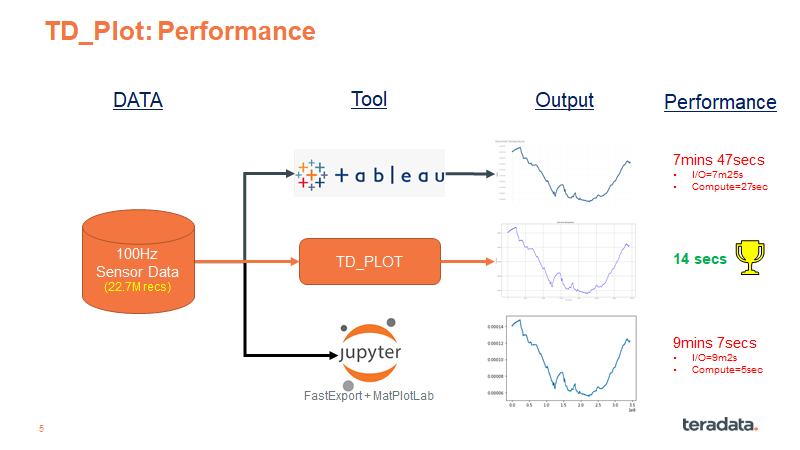

<h3 style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Line Plot</b></h3><p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Description</b><br>
A line chart visualizes data as a series of plot points, each connected by a straight line. It is a key decision-making tool for comparing changes across different set periods. Most often line charts are used to show changes over periods of time. The line chart in this demo demonstrates the relation between the time_series and the weekly sales.<ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li>On the X-Axis You'll find the timeseries</li><li>On the Y-Axis you'll find the Amt (target column)</li><br><b>Function Significance</b><br><ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li>We plotted the line chart to understand the trend between the time series and the weekly sales.</li><li>The other reason is that we can see the general trend of the number of sales over certain time.</li></ul>
    <br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b> 
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>You can use line charts to help inform business decisions for a wide range of use cases across departments, including:
    <li>Highlight department spending</li>
    <li>Track stock movement</li>
    <li>Compare historical revenue between products</li><li>Identify customer satisfaction scores</li>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_Plot function 

<p style = 'font-size:16px;font-family:Arial;color:#00233C' ><b><i>* Right click on the image column and select view image. 

In [20]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(resampled_atm_data),
        ROW_AXIS(TIMECODE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD
        (
           FIELDS(Amt),
           CONTENT(REAL)
        )
    )where cast(row_i as date) <= '1996-04-18',
    FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('LINE GRAPH'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('TIMESERIES'),
                YLABEL('Amt')
            )
        ],
        WIDTH(1200),
        HEIGHT(500)
    )
);

idcol ROW_I IMAGE 1 0 0 89504e470d0a1a0a0000000d49484452000004b0000001f40802000000a2b24345000000097048597300000f6100000f6101a83fa7690000200049444154789cecdd796054e5b93ff0ef9925fb24934c12b20cd9c39ab08349804aaba040aba5aea0e0d6aad7a585daebede6c556ad3feff55a5badb5b556aab5d8d602b58a0bd60543d8644dc2923d903d33d966c924b39cdf1f27c690843049669fefe72f727296672c2579cefbbccf2388a2082222222222220a3e326f0740444444444444dec184908888888888284831212422222222220a524c08898888888888821413422222222222a220c584908888888888284831212422222222220a524c08898888888888821413422222222222a220c5849088885c4ca9542a95ca719d201d9932654a4f4f8f93278fca99f01a1a1a9e78e289fcfcfc989898f0f0f0a4a4a4e5cb97fff0873f3c71e2c4a88f96848686a6a5a5dd7efbed25252517bbf38a152b944ae5e5975f3ef6071fbc614e4ece962d5b6a6a6ac6febcce7c8b88886862045114bd1d03111105144110008cf1f365e409d211008f3efae8d6ad5b9d3c79a4b17fa8391c8e9ffef4a74f3df594c3e170e6f2511f2493c93ef8e0832baeb862d8f1bababacccc4ce9cfd5d5d559595923af1df5866ab5fad0a143b9b9b943cf19f5835cf23f2c1111d17871859088887cc833cf3ca3d3e99c39d33a9ab12f79f4d1479f7cf249994cb671e3c6f7df7fbfb3b3b3b7b7b7a5a5a5b8b8f817bff8c59c3973c67890d1683c7af4e8ca952b1d0ec7534f3d35f2b4d75f7f7df0cf7ff9cb5f2e19794f4fcfc71f7f3c6ddab4aeaeae679f7dd6894f4c4444e47a5c21242222179bf00ae19a356b76efdefdd0430f3dfdf4d3973c79bc3fbf9a9a9aa64e9d0a60f7eedd575d75d5c81344511cb68237f2410d0d0d53a74e0d0b0bebeded1d76ed8c19332a2a2a1e7cf0c1e79e7b2e3737f7ecd9b323d70347def0c08103858585c9c9c94d4d4d97fc745c2124222297e30a211111f98ac71e7b0cc06f7ef39b86860697dffc1ffff887c3e1d8b061c3a8d920c6ac441d2493c9004445450d3b7ee4c8918a8a8ac4c4c4fff99fff494c4cacacac3c7cf8b03351e5e7e703686f6f77e664222222976342484444be62c18205d75f7fbdc562f9f9cf7feef29bbff1c61b00aebbeeba895d6eb55a4f9f3efd9def7c07c0aa55ab867df7b5d75e0370f3cd37878585dd7cf3cd00fefce73f3b73dbf2f272001a8d6662511111114d124b468988c8c5265c322a8ae2e9d3a7f3f2f26432d9a953a7a43e2b173b59a1508cbcf318db08351a4d4747874ea7733efb1afa209bcd261d2c2a2adab973676262e2d0876ab5dab6b6b6c3870f2f5ab4e8c891238b162d4a4c4c6c686818d61474e867e9ebeb3b76ecd83df7dc73f2e4c97beeb9e7c5175fbce4a79362e00f6e2222722126844444e462934908016cdab4e9b5d75e5bbf7ebdd49ac5555d46954aa5cd66b35aadc372ad6139dbd09472e483e2e3e3fffdef7f0f6b3fb37bf7eeb56bd74e9b36edcc9933822088a2386bd6ac3367cebcfdf6db6bd7ae1df9c1876598d1d1d1070e1c983973e6253fdd253f231111d178b1649488887ccbcf7ffef3909090eddbb78f1c0c38d478bb8c46474703e8eeee1e76dc76a1511fd4dfdf5f5151b176ed5a9d4ef7f5af7fdd68340e3d41aa0eddb4699394cb0982b069d3265cd87774e41301a4a6a6de77df7d870f1f1ecc0627fce988888826862b844444e462935c210470fffdf7bff0c20b6bd7ae7dfbedb75dd56574f9f2e5c5c5c53b76ec58b76eddd0e38349a0b45438c6837a7b7b172c5870e6cc99c71e7beca73ffda974b0a7a767ca9429168ba5b6b6362323433a585f5f9f9191111616d6dada2a25a2436f28a57632994c6a5173c9ff3893fce044444463e00a211111f99c9ffce427616161efbcf34e494989abeeb961c30600dbb76f1f765cf1854bde213c3c5c9a87f1dc73cf0d8e9dd8b973a7c56201909b9babfc424e4e0e008bc5b273e7ce91f7911e376a36484444e461fc694444443e272525e581071e00f0a31ffdc855f7bce1861b140ac53ffef18f1d3b764cf8266bd6ac993f7f7e5b5bdbabafbe2a1d91fa8be222a5a783df252222f24d2c19252222179b7cc928009d4e979d9dddd3d3237d39f99251004f3df5d40f7ff843994c76c30d37dc74d34d2b56ac50abd57d7d7d3535357bf6ecd9bc79b3330f7ae38d37d6af5f9f9b9b7bfaf4e9e6e6e6f4f4748542d1d0d0101b1b3bf4b4cece4ead566bb3d9eaebebb55aadf391b3649488883c892b844444e416cad1387f797c7cfc962d5b5c7bff871f7ef8c9279f94c9647ffdeb5fbff5ad6fc5c5c5c964b2f0f0f0d9b3676fdebc59ad563b333cf0faebafcfccccacacac7cebadb7b66fdfee7038aeb9e69a848404c585121212d6ac59e370384616a9121111f90eae101211918b5d722c84937d62babbbbb3b2b23a3a3a463d798cfb8fadadaded6f7ffbdbebafbf7ee6cc19a3d1a856ab67cf9ebd76eddaef7ce73b6ab57ae4071979cfe79f7ffec1071f2c2828309bcd274f9edcb56bd7b5d75e3bf2413b76ecb8eebaebe6cc9933d82e952b844444e46b98101211111111110529968c12111111111105292684444444444444418a092111111111115190624248444444444414a4981012111111111105292684444444444444418a092111111111115190624248444444444414a4981012111111111105292684444444444444418a0921111111111151906242484444444444

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In the plot above we can see the daily amount of atm for a month. Try changing the where condition to see the plot for a different month or for the whole set of data.

<h3 style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Bar Plot</b></h3><p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Description</b><br>
An excellent way to compare objects with the same parameters, a bar chart plots numeric values as bars. The Bar Chart in this demo demonstrates the relation between months and sum of cash flows.<ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li>On the Y-Axis you'll find the Sum of cash flows over a month</li><br><b>Function Significance</b><br><ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li>(*w.r.t our use case*)It would be good to have if we have this type of visualization in which we can see the cash flow within months over a period. We can identify the month in which the cash flow increase, which months are highlighted for highest and lowest cash flows by analyzing the data from past few years etc.</li></ul>
        <p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> 
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>We can use bar charts to help inform business decisions for a wide range of use cases across departments:
    <li>Compare revenue between businesses</li>
    <li>Highlight budget variance</li>
    <li>Visualize best to worst performers</li>
    <li>Categorize survey responses</li>
     <li>Track historical sales performance</li>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Creating a table which will have the monthly sum of cash flows over months for a year. We Do this by extracting month and year from the date column , applying Sum on the cash flows (Amt) and then grouping them on the bases of months and years this would give us the sum of monthly cash flows for years.

In [21]:
CREATE VOLATILE TABLE monthlyavg_atm_data AS ( 
    SELECT 
    EXTRACT (MONTH FROM ROW_I) as "Month_",
    EXTRACT (YEAR FROM ROW_I) as "YEAR_",
    SUM(Amt) as Amt
    FROM resampled_atm_data
    GROUP BY Month_,YEAR_) 
WITH DATA
on commit preserve rows;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Printing the rows from the table and ordering them by month and year

In [22]:
SELECT * FROM monthlyavg_atm_data ORDER BY YEAR_,MONTH_;

Month_ YEAR_ Amt 1 3 1996 264.18699999999995 2 4 1996 560.217 3 5 1996 628.7829999999999 4 6 1996 528.0610000000001 5 7 1996 624.9140000000001 6 8 1996 645.241 7 9 1996 580.8449999999999 8 10 1996 645.4929999999999 9 11 1996 606.0030000000002 10 12 1996 689.672 11 1 1997 576.297 12 2 1997 567.812 13 3 1997 653.3929999999999 14 4 1997 656.1175 15 5 1997 628.9130000000001 16 6 1997 626.2415 17 7 1997 712.7774999999999 18 8 1997 635.6615 19 9 1997 673.0034999999998 20 10 1997 742.3174999999999 21 11 1997 722.024 22 12 1997 764.5539999999999 23 1 1998 682.3159999999999 24 2 1998 689.6115 25 3 1998 481.89500000000004

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_Plot function 
<p style = 'font-size:16px;font-family:Arial;color:#00233C' > <b><i>* Right click on the image column and select view image. 

In [23]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(monthlyavg_atm_data),
        ROW_AXIS(SEQUENCE(MONTH_)),
        SERIES_ID(YEAR_),
        PAYLOAD
        (
           FIELDS(Amt),
           CONTENT(REAL)
        )
    )WHERE YEAR_=1996,
    FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('BAR GRAPH'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                TYPE('bar'),
                LEGEND('best'),
                XLABEL('MONTH'),
                YLABEL('Amt')
            )
        ],
        WIDTH(1200),
        HEIGHT(500)
    )
);

YEAR_ ROW_I IMAGE 1 0 0 89504e470d0a1a0a0000000d49484452000004b0000001f40802000000a2b24345000000097048597300000f6100000f6101a83fa7690000200049444154789ceddd797c55e59d3ff07343c29a0d310425222a08eea885a2af5ae9222e58ad63b508028ab6f5a795c552756a5b224a995a15acce94b6e3d4a58c3a63457069c7a52a8a563bd04a2dc4d40dd9040904120c24e1dedf1fb7cdc4042e01727321cffbfd87af73bff72cdf93de72f3c9f39c7362894422020000203c59996e00000080cc1008010000022510020000044a2004000008944008000010288110000020500221000040a0044200008040098400000081120801488b9c4f2b2a2abae8a28b9e7ffef9149b0c1b362c2727e7f4d34f6fc93e3b75ead4a74f9fcb2ebbecd5575f6d79572b57ae9c3e7dfa71c71d575050d0a54b975ebd7a9d76da6937de78e39b6fbeb997c7dadde6fbf5eb3779f2e4f7de7baff93a29366ff99902404bc4128944a67b00a01d8ac5623baccf9f3fff2b5ff94af3fa071f7c70d861872597df7df7ddc30f3fbc85fbcccaca7ae69967bef4a52fa5ee271e8f7ffffbdffff18f7f1c8fc777b842932fc4dd3ad61e375f5858f8c61b6ff4efdfbff13a3bfc6a4ef11600ec31238400a4515d5d5d5d5d5d4d4dcdb265cbce3ffffc288a7ef4a31fed70cd3973e6342cffe77ffee72ef7595d5dbd78f1e233ce38231e8ffff8c73fde6527a5a5a53366ccc8caca1a3366ccfffccfff6cdcb8b1a6a6e6a38f3e7ae595577ef4a31f1d7ffcf17b73acdd6d7ef3e6cd2fbcf0c291471e595959396bd6ac5d360f006962841080b4683ea2b566cd9a830f3eb863c78edbb66d6bb2722291183870607979f9b5d75e7bf7dd77f7efdfffedb7df6e3ea4d67c9f2b57ae3ce490433a77ee5c535393a299d5ab571f72c82151143dfdf4d3679e7966f31512894493c3b5fc587bdcfc1ffef087534e39e5a0830e5abd7af5ced649b13900ec3d238400b491acacac288aba77efdefcad458b16959797f7ecd9f3b6db6eebd9b3e7dffef6b73ffef18f2ddf676e6e6eead57ef39bdfc4e3f151a346ed300d463b9fe0da9263ed71f3c71d775c14451f7ffc714b5606807410080148bb783cbe7cf9f2891327465174f1c517375fe1c1071f8ca268e4c8919d3b771e3972641445bffef5af53efb3aeae6ed9b265dff8c637a2281a3e7c78ea951f7ef8e1288a2ebcf0c23d6a7f17c7da83e693fefad7bf4651d4a3478f3deb0a00f69e29a300a44572cc2d3b3b3b8aa2783c1e8fc7f3f3f3bff18d6fdc7aebad9d3b776ebc665d5d5d4949c9ba75ebfef8c73f7ee6339f59b468d1673ef3999e3d7bae5cb9b2c97d351befb3bebe3e593cf5d453e7ce9ddbb367cf14cdf4e8d163c3860debd7af6f79fa6ae1b176b7f9e4d7eeb66ddbfef4a73f7deb5bdf5ab264c9b7bef5add9b367373f6813c91e7c6b03d0ba8c10029046f5f5f5f5f5f5c91b7b6edebc79c182056fbcf14693759e7df6d975ebd61d79e491279f7c721445279d74d2c08103d7ad5bf7cc33cfa4d86772f9c0030ffcd9cf7e963a0d260f1d4551414141937a936763ecc1b176b7f9e4813a77ee7cca29a72c59b2243f3f3f3970dafca04da43e4100d8330221006994bca9666d6dedead5ab1f7becb1cacaca2f7de94bcf3efb6ce37592132cc78e1d9b1c1f8bc56263c78e8d3e7debce26fbacadad2d2f2f1f3162c4faf5ebcf3df7dceaeaead46de4e7e74751b469d3a626f55d86ae5d1e6b779b6f3850efdebdafbefaea3ffef18f471d7554f3833697fa040160cf98320a405aecf0ae980b172efcdce73e77fae9a7bff8e28bc9cae6cd9b8b8b8bb76eddfafefbeff7eddb37595cbe7c79dfbe7d3b77eebc76edda6496dbe13e6b6a6a4e3ae9a4b2b2b25b6eb9e5fbdfff7e8a664e3bedb4575e79e5b1c71ebbe0820b1ad71b42607278b071b72d39d61e349f8c76595959c95bd4b4e487b6cbb700608f192104a0ed9c74d2495114bdf6da6b0d95b973e76eddba358aa2fefdfb374cddecd7af5f14455bb76e9d3b776e8abd75e9d2e5f6db6f8fa2e8eebbef4efdd88951a3464551f4d0430f35a967ffc32e3bdfe1b1f6a0f9e4e176980601a0edf94202a0edfcf9cf7f8e3efde486e42d3aa39dccde6c787767ce39e79c134f3c71ddba750f3cf0408ad52ebae8a2ecececdffce6378f3df6d81e37dffc587bd93c00649c400840da2512890d1b363cf5d453e3c68d8ba2e8a28b2e4ad657ae5cf9c20b2f74ecd871ddba754d2e995bb76e5dc78e1d5f78e185952b57a6d8732c16bbfefaeba328bae38e3bb66fdfbeb3d50e3cf0c05b6fbd351e8f5f74d14523478e9c3b77eec68d1b1389c4d6ad5b972e5d7ad75d77b5e42c9a1c6bef9b07808c13080148a3e42ccaececec1e3d7a9c7beeb97ffbdbdf7af6ec79e38d3726df7de8a187e2f1f879e79d57545494fd69454545e79c734e3c1e6f3ecfb389af7ded6b871d76d8dffef6b7f9f3e7a758edfaebaf9f3163465656d6238f3cf24ffff44f071c7040565656972e5d8e39e698499326151616b6e4e1818d8fd52acd034066098400a451c36327ba76ed3a78f0e0ef7ffffb4b962c69b8ff4a32835d7ae9a53bdc76cc9831510b1ef29e9d9d7ddd75d7455174db6db7a5582d168bdd78e38dab56adbafbeebb870e1d5a5858989d9d7de081079e7efae9b7dd76dbfbefbf3f7af4e85d9e4ee363b54af3009059ee320a000010282384000000811208010000022510020000044a2004000008944008000010288110000020500221000040a004

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In the plot above we can see the monthly average cash flow for the year 1996. Notice that the graph starts from March because we have data in the dataset starting from March, 1996.

<h3 style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Seasonal plot of month over year</b></h3><p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Description</b><br>
The seasonal plot of month over year actually is a line graph It is plotted to visualize the trend of cash flow over month and uniquely identifying the trend for each year. It is build to see if the trend repeats each year or not.

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_Plot function 
<p style = 'font-size:16px;font-family:Arial;color:#00233C' > <b><i>* Right click on the image column and select view image. 

In [24]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(monthlyavg_atm_data),
        ROW_AXIS(SEQUENCE(MONTH_)),
        SERIES_ID(YEAR_),
        PAYLOAD
        (
           FIELDS(Amt),
           CONTENT(REAL)
        )
    ),
    FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('SEASONAL PLOT OF MONTH OVER YEAR'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('TIMESERIES'),
                YLABEL('Amt')
            )
        ],
        WIDTH(900),
        HEIGHT(500)
    )
);

YEAR_ ROW_I IMAGE 1 0 0 89504e470d0a1a0a0000000d4948445200000384000001f40802000000ea917484000000097048597300000f6100000f6101a83fa7690000200049444154789cecdd795c5455ff07f0cfecc33aec3b88e08a8822b964eefb96e692296aa6a6f9689958faf4d4d32f2d2d9f322db3456dd172cf5d33975c5073414504975c4005641566866df6b9bf3f66448461188681cbf27dbf7af58273cf39f77b679cb95feeb9f71c0ec330208410420821840d5cb6032084104208214d1725a384104208218435948c124208218410d650324a08218410425843c9282184104208610d25a384104208218435948c124208218410d650324a08218410425843c9282184104208610d25a3a4c9c9c9c959bc78716464a48383839393536464644c4c4c7c7c7cb96a82ca99ecb64f9f3e0281a077efde35dc6f69e52fbef8a243870e1289442291b46fdffe7ffffb5f4e4e4ec59a8690bcbdbd0b0a0a4c6eb22e5a336dcd37311089442d5ab4888989494949a96eb7961cbb9977c7fcdb54adbd98df9785afc6a44993ca6d8a8e8e36d389cddf7acb5f2b33c765c9215b1e7f6464a44020d8bb77afc91ef6ecd9231008222323cbedbdca77a16cb948240a0a0a7aedb5d7ce9d3b673ee0d1a3470b0482d1a347972b6718c6b069ecd8b1d50aa394859fb2ea064c4823c410d2943c78f0c0d7d7d792cf42b53e35f7efdf2fdd9a9c9c5c93fdeaf5fa2fbef842281456ac29140abff8e20bbd5e6f32cec58b179b3c042ba235d3d60c9347e7e2e272e7ce1d0bbbb5fcd8cdbc3b95bdb056ecc5fcbe2c7c35eceded0b0b0b4bcb0b0b0bededed4d76524b6fbde5af9599e3b2e4902d8f7ff9f2e500c68d1b67b29f3163c60058be7c79c52335ff2e98acc0e572fffaeb2f3361a7a6a63a3a3a02d8bd7b77d9f2ddbb77037076764e4b4bab561806967fcaaa1b30218d0f25a3a469993d7b3680d0d0d0ddbb77676565151515ddb87163f5ead5919191e56a1a4e0c1a532a76bb74e9d2d273c9279f7c5293fdae5ebddad0cfa851a30e1f3e2c93c96432d9d1a3475f7ae92543f9ead5ab2bc669386be6e6e656dc6445b466da9a51f6152b28283879f264ab56ad00cc9933c7c26e2d3ff672ef88c937abe67ba9785c96f45fb655f7eedd016cd9b2a5b47cd3a64da5e5e55e8a5a7aeb2d7fadccbc3b96fc7bb03cfed4d4542e972b140aa55269b94ef2f3f385422197cb4d4d4d2db7f72a3f8c65ab151515c5c7c70f1c3810c0c08103cd47fecd37df00f0f5f595c9648612a9546af8eb71cd9a35d50dc3c0f24f99150113d2c850324a9a1637373700972e5d2a575eee9a13539d6c4cafd71bb2aeb7de7a0b40cb962d2bf666e17ef3f2f20c1796d6af5f5f7147ebd7af0720140af3f2f2cac5396cd83000efbcf34e95876049b495b535af6293f3e7cf1bcef196746bc5b15b11add5afb0259d570c69cd9a3500860f1f5e5a3e7cf87000df7df75db96eebe0adafa54dd6c5dfb76f5f93950d35fbf6ed5badbd57562d2d2d0d80582c36df50abd576ebd60dc0ecd9b30d256fbcf106806eddbae974baea86c1d4e0536661c0843432948c92a6c570beac783da622cb4f3c972e5d02e0e5e5a55028bcbcbc005cbc78d1bafd1acec4c3860dabac8221f3287b0a37c479e5ca15c339ac7448b1b243b024dacada9a57b149515111003e9f6f49b7561cbb15d15afd0a5bd279c590b2b3b3f97c3e9fcf7ffcf831c3308f1f3f36fc5a7a0f65cd03b3fcadafa54dd6c5fff3cf3f03e8ddbb77b96abd7af502f0f3cf3f576bef95557bf4e811000f0f8f2adb262626f2f97c0067cf9e3d73e68c21754e4a4ab2220ca6069f32cb0326a431a1079848d362b8feb170e1c2fcfc7c5bf5f9db6fbf0198306182582c9e30610200c350ac15fbddb2650b80e8e8e8ca2a183655ecbf53a74ee3c68d532a951f7ffc71cda3b5951b376e00707777b7a4b2d5c75e2d75b397525e5e5efdfaf5d36ab5bb76ed02b073e74ead563b60c0004f4f4f5b0566f95b5fabaa1bffd8b163c562716c6c6c6a6a6a699d870f1f9e3e7d5a2c161b6e1bad098d4673ebd6ad993367021834685095f5dbb76fffde7bef0178fdf5d70dad162d5a141e1e6edddeadf894553760421a15b6b36142ead4a143870cd73ff87c7ed7ae5ddf7aebadad5bb716171757ac69f880f04d295b4dad561bae7c1886e02f5fbe0cc0cbcb4bad565bb15fc3687e76767665f1676767037073732b1727c330376fdee472b97c3ebff481a18a9f710ba335d9b64a659b2895caf3e7cf4744440078e38d372ce9d68a63b7225aab5f6133ff064c2a0d69e3c68d787209d0f060f5c68d1b2bc65cdb6f7dc556956d32f96fbeca57d88af85f79e515009f7df65969c9a79f7e0ae0e5975fb63cb0caaa959ee3ba77ef6e26aab2140a85616c1d40ab56ad140a85756154f7536675c084341a948c922627212161d8b061659ff9f5f0f058bd7ab585cf50973b25fff1c71f865397a1b95eaf6fd3a60d8083070f5ab15fc339a9e249ab945aad46e503df53a64c013071e2c48a9baa1b6d95c9474526cfaccecece376fdeb4a45b2b8edd8a68ad7e85cdfc1b30a9b49a5c2e178bc55c2ef7c2850b5c2e572c16cbe5f28a31d7f65b6fb295c94d16fecb2fc78af80f1c3800202c2cacdcbfc603070e581e98f96a1e1e1ed7ae5d33137639b1b1b18686b1b1b115b75a1846753f6535099890c6819251d2441516161e3d7af4934f3ee9dab5abe13460b85e55ca5058e593b313274e04b074e9d2d212c3d59dd2b4a05afb355c5ecac9c9a9

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From the monthly graph above above we can see that there is slight upward trend in cash flow in 1996 and 1997 but they dont follow the same pattern.

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_PowerSpec</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_PowerSpec</b> Converts a series from the time or spatial domain to the frequency domain in order to facilitate frequency domain analysis. Its calculations serve to estimate the correct power spectrum associated with the series.<br>Please refer <a href ='https://docs.teradata.com/search/all?query=TD_POWERSPEC&content-lang=en-US'>here </a> and Function Output are <ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li>Derived-series-identifier: The resultant series identifier inherited from the SERIES_ID.</li><li>ROW_I: The index of time series.</li><li>SPECTRAL_DENSITY_field: The calculated magnitude.</li></ul>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> 
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>TD_PoweSpec helps us to visualize the data in the frequency domain.</li><li>We can identify different patterns in the series, and all this processing is done in IN_DB so Teradata is Maintaining the processing time to a minimum.</li>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_PowerSpec function and building the table for the results

In [25]:
EXECUTE FUNCTION INTO VOLATILE ART(PWRSPEC_RES_tw) 

TD_POWERSPEC( 
    SERIES_SPEC(
    TABLE_NAME(resampled_atm_data), 
    SERIES_ID(idcol),
    ROW_AXIS(TIMECODE(ROW_I)),
    PAYLOAD(FIELDS(Amt), CONTENT(REAL))),
    FUNC_PARAMS( FREQ_STYLE("K_RADIANS") ));

Success: 375 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Printing top 5 rows of the table

In [26]:
select top 5 * from PWRSPEC_RES_tw;

idcol ROW_I SPECTRAL_DENSITY_Amt 1 1 0.008377580409572781 0.8286777834516171 2 1 0.016755160819145562 0.7044740379449644 3 1 0.025132741228718346 0.37851462708328915 4 1 0.033510321638291124 0.15623333771625625 5 1 0.04188790204786391 0.08693791946113759

<p style = 'font-size:16px;font-family:Arial;color:#00233C' >Let us plot the power spectrum.
<p style = 'font-size:16px;font-family:Arial;color:#00233C' > <b><i>* Right click on the image column and select view image. 

In [27]:
EXECUTE FUNCTION 
TD_Plot
(
    
    SERIES_SPEC
    (
        TABLE_NAME(PWRSPEC_RES_tw),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD
        (
           FIELDS(SPECTRAL_DENSITY_Amt),
           CONTENT(REAL)
        )
    ),
   FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('POWER SPECTRUM RESULTS'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X ROW_I in W K_RADIANS'),
                YLABEL('Y SPECTRAL DENSITY MAGNITUDE')
                ,GRID(FORMAT('-'))
            )
        ],
        WIDTH(900),
        HEIGHT(500)
    )
        
);

idcol ROW_I IMAGE 1 0 0 89504e470d0a1a0a0000000d4948445200000384000001f40802000000ea917484000000097048597300000f6100000f6101a83fa7690000200049444154789cecdd797c54f5bdfff1ef9925936db2904010223b880a08a4480041ad7bb0b55c71218ae8c5aa5551a2a26dfdf541847245110a1611f5f6164b351451c1a55aa554508a1b201ad6b2853521649dec3373ceef8f43c6c9643239594e26e7e4f5fc83c7e4cc99733e734226ef7ccf7791144511000000403858c25d00000000ba2ec228000000c286300a000080b0218c020000206c08a3000000081bc228000000c286300a000080b0218c020000206c08a3000000081bc228d0a9d9fd381c8e4183066565651d3e7cb8f19e67ce9c59b468d125975c121f1f1f1f1f3f7cf8f0e79e7beecc993301bb0d1830c06eb7efddbbd77fe3942953d453dc70c30dfedbf7ecd963b7db070c1810b49e0021caeed3a7cfdd77dffdef7fff5bcb5b3e73e64c7676f6a851a36262629c4ee7a851a3b2b2b276ecd8d18a2ba3b15a557171f1f2e5cbd3d3d39392921c0e47f7eeddc78d1bf7d4534feddcb933f4a1028ea9fdbd375549d0a77cc7bce38e3b0276cecccc0cf1be425cb4666b6bf6d2b5e89bd5a277aabd9e80c2349604a01351007462417f6c1312120e1c38e0db4796e5458b1645444434de33222262d1a245b22cfb769e366d9a10e295575ef16df17abdc9c9c9eafe7171711e8fc7f7d4cb2fbf2c84c8cccc0c5d4fe30f93a03b582c968d1b37867ebf478f1e3defbcf3b47c5869b9321aab9565f90f7ff843d00be8db39c4a1028e19f4a9a0ef3de8fb6aea29dfa1a2a3a35d2e976fbbcbe58a8e8e0efabe9a3aacf6da42bc4da5e5dfac16bd53edf5f89f547b49003a0f5a46010370bbdd6eb7bbbcbcfc5ffffad79021434a4b4b972e5dea7b76f9f2e573e6cca9ababbbe9a69b3efef8e3d2d2d2d2d2d24f3ef9e417bff8455d5ddd9c3973962f5feedb79e2c4894288cf3fffdcb765fffefd67cf9e3defbcf3faf7ef5f5e5e9e9b9beb7b4add4d7d49e37a023455764545c58e1d3baeb9e61a59969f7beeb9d0ef74e1c285a74f9f1e3870e03befbc939f9f5f5151b17bf7ee175f7c71d4a851adb8321aab5dbe7c795656967a01df7efbed3367ce5457579f397366dbb66dcf3ffffcc891231b1f24e891dbf8deb5183f7e7c5555d5fbefbfefdbb261c386aaaaaaf1e3c76b3f88f6da425fba967eb3da42e3f5efc89200b49b70a76100a134fe39ddb66d9b10e2bcf3ce53bf2c2a2a529bf45e7bedb5c62f7fedb5d78410111111454545ea96efbfff5e08d1b76fdf807d6eb9e5963befbc5308b162c50a75bb2ccbbd7bf71642ecdebd3b443d1acb3e7efcb81022323232f40bbb75eb2684f8e69b6f02b6fb37ee36758a802ba3b15adf055cb56a55d01d1a9f3af491b5bff7161d44dda2fe5d3179f264dff6c99327abdf352d6fb65d6af369cb372bc453ad7b232d2d0940e741cb286030c3870f1742141616aa5fbef3ce3b757575191919f7de7b6fe39defbdf7de8c8c8cbababa77de7947dd72f1c51777ebd62d2f2f4f4d2142882fbef842083171e2c409132608bf46d3bcbcbc93274f76ebd66de8d0a16d2fdb62b1082162636343ef565151218418346850c07649929a3d45c095d168ddba756a9be88c193382eea0e5d4a1697cef5adc72cb2d369bed1ffff84751519110a2a8a8e81ffff887cd669b3a756ac7d7d6966f964e3a6149009a4518050c66f7eedd4288a4a424f5cb37df7c5308919999d9d4feea537ffdeb5fd52f2d16cbb871e3447d061542a8e357c68f1fafdeeaf56df7dda357f34aabb9ddeebd7bf7fef297bf14425c7bedb5a1774e4f4f1742cc9933a7b8b8b8a5270ab8321aa91750ed4adbee5af4deb5e8d1a3c74f7ffa538fc7f3f6db6f0b21d6ad5be7f178aebefaeaeeddbb777c6d6df966e9a4139604a079e16e9a05108affcf694d4dcdb66ddb468c182184b8fffefbd58dea7dc9828282a68e5050502084e8d6ad9b6fcbf3cf3f2f8478e081071445c9cfcf1742c4c6c6badd6e8fc71317172784387efcb8a2286a53eba2458b1ad7630ba6a9dd7c9f36e3c78f0f51a7eaef7fffbbfa129bcd3676ecd859b366e5e4e4545656b6e2ca68ac56bd8067ce9c095d5888b3077d4acb7b6ff62041b7bcfefaeb4288cb2fbf5c5194cb2fbf5c08f1faebaf873e5aab6b0b7de95af7cdd2fe4e9b7d238db76b2f0940e74118053ab5a0e9212e2e6ecf9e3dea0eeaf6bababaa68e505757a71ec1b745ed5b396cd8304551d4dbf7d75c738dfa94da42b666cd1a4551860c192284f8eaabaf1ad71354e8dd92939377eddaa5e52d7ff7dd77191919fe63db9393935f7cf1c5806e7fcd5e198dd5367b01836a365d6979efcd1e24e896b2b2b2c8c8488bc5f2e5975f5a2c96c8c8c8b2b2b2d0476b756da12f9dd2c26f564bdf69b36f24e8531a4b02d0791046814e2d2007f4eeddfbc1071fdcbf7fbf6f87661bf6d43e94fe2da3b5b5b59191914288b367cf6665650921e6ce9dab3e357ffe7c21c4ac59b3d4f6d4e8e8e88094a69611749075d0ddeaeaea0e1c38a00eb239fffcf3fde7240acde5727df2c927f3e7cf1f3b76ac7a34b5fd4ffb95d158ad7a01cf9e3dabb130ff2387784acb7b57f76c1c9264590e1dd1d41ea283070f1642dc72cb2dcd96d4eada9afd46ab347eb35af14e43bf91103b345b1280ce83300a746afe99c0ebf536de61d2a44942889c9c9ca68e909393238498346992ff46f5f6ee860d1bd45fd5be6926376dda248418356a

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The power spectrum plot provides information about the intensity or magnitude of each frequency component present in the signal. The power spectrum indicates how the power or energy of the signal is distributed across different frequencies. From the above power spectrum plot we can see that there is only one significant frequency and not many other frequencies hence we can conclude that there is not much noise in the data.

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_ACF</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_ACF</b> Calculates the autocorrelation or autocovariance of a time series. Autocorrelation and autocovariance show how the time series correlates or covaries with itself when delayed by a lag in time or space. When TD_ACF is computed, a coefficient corresponding to a particular lag is affected by all the previous lags.<br> Please refer <a href ='https://docs.teradata.com/search/all?query=TD_ACF&content-lang=en-US'>here </a> for more information.<br> 
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Function Significance</b> 
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.</li>
    <li>Autocorrelation measures the relationship between a variable's current value and its past values.</li>
    <li>An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.</li>
    <li>Technical analysts can use autocorrelation to measure how past influence affects security prices.</li>
     <li>If You want to visualize how much previous values are impacting your current value or how much dependent the current value is on the previous values then you have to use this function.</li></ul>
     <p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Business Value</b> 
     <ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>This exploratory analysis is useful for identifying how many previous values are impacting the current value in this data of cash flows<ul><li>Sales</li><li>Expenditures vs Revenue</li></ul></li>
    <li>Teradata can help us find autocorrelations for years with high performance, efficiency, and speed as compared to others. It can process millions of rows and find the autocorrelation for you within seconds.</li></ul>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_ACF function and building the table for the results

In [28]:
EXECUTE FUNCTION COLUMNS(OUT_Amt AS Amt) INTO VOLATILE ART(ACF_RES_tw)
        
TD_ACF ( 
    SERIES_SPEC(
    TABLE_NAME(resampled_atm_data),
    SERIES_ID(idcol), 
    ROW_AXIS(TIMECODE(ROW_I)),                             
    PAYLOAD (FIELDS(Amt), CONTENT(REAL))),
    FUNC_PARAMS(MAXLAGS(14), FUNC_TYPE(0), QSTAT(1), DEMEAN(1), ALPHA(0.05) ));


Success: 15 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Viewing the top 5 rows of the table.

In [29]:
select top 5 * from ACF_RES_tw;

idcol ROW_I Amt QSTATVAL_Amt PVAL_Amt CONF_OFF_Amt CONF_LOW_Amt CONF_HI_Amt 1 1 0 1 0 0 0 1 1 2 1 1 0.5136851571896923 194.47506877748978 0 0.07234359075662113 0.4413415664330712 0.5860287479463134 3 1 2 -0.11815037736464508 204.777340953958 0 0.0894181086890065 -0.20756848605365158 -0.028732268675638578 4 1 3 -0.5505041582584028 428.7410776732716 0 0.09023145253147896 -0.6407356107898818 -0.46027270572692386 5 1 4 -0.5493007192264586 652.032144911371 0 0.10636657166913374 -0.6556672908955924 -0.44293414755732485

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_Plot function for plotting.
<p style = 'font-size:16px;font-family:Arial;color:#00233C' > <b><i>* Right click on the image column and select view image. 

In [30]:
EXECUTE FUNCTION 
TD_Plot
(
   SERIES_SPEC
    (
        TABLE_NAME(ACF_RES_tw),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD (FIELDS(Amt, CONF_OFF_Amt),CONTENT(MULTIVAR_REAL) )
    ),

   FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('ACF RESULT SERIES'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
               TYPE('corr')
               ,XLABEL('X LAG')
               ,YLABEL('Y Magnitude')
            )
        ],
        WIDTH(900),
        HEIGHT(500)
    )
            
);

idcol ROW_I IMAGE 1 0 0 89504e470d0a1a0a0000000d4948445200000384000001f40802000000ea917484000000097048597300000f6100000f6101a83fa7690000200049444154789ceddd797c54f5bdfff1ef6c59209385988c4840d004282e10312c2e15372cd06ba9179445042d5a8b253e50512bd74b24d208a294c58d7bb1554a01ad0b566a7f2ed8dac6aa9854bc0869aa014c6a202c49988484cc99f3fdfd71c230994c92992433df99e4f5ece341cff23de77ce64872de7ccf39df31492905000000a082597501000000e8bd08a30000005086300a0000006508a30000005086300a0000006508a30000005086300a0000006508a30000005086300a0000006508a300023261c2049bcd76d55557b5dfecf8f1e3ebd7af1f376e5c6a6a6a6c6c6c5a5adaf8f1e31f7ae8a17ffce31f9e36b636b4bf67ef96b1b1b183060d9a376fdec71f7fdc7ecb760e515555959797979d9dddb76f5fbbdd9e9d9dbd68d1a2e2e262bf7b6ba7a40e1bb7534f879f3da8223bdc73b0e7b0138708b06000f030f175a0003a74e0c08121438618d3df7cf3cd79e79dd7ba8d9472cd9a350f3df450535393df9d787edb984ca6f61bf8e5772bb3d9fceebbef5e7bedb51db6f439c4c18307c78f1f5f5959d96119c6defcd6d67a95dfc6edd4d3d6413b5764877b0ef61c76b8adcf21022f18003ce81905d0b1cd9b377ba67ff7bbdff96db37efdfa458b16353535fde8473f7aedb5d7aaaaaa1a1a1aaaaaaafefef7bfaf5cb972d4a8513eed5dad045289d1b2aeaeaeb8b8f8faebafd7757dc58a15edb46ceb104f3cf1446565e5f9e79ffffaebaf1f3a74a8aeaeeeabafbe5abb766d767676206504c56f0d817cf6608b6cff23fb340be41c067b88709e55003d063da3003a20a51c3e7c786969e9c2850bd7ad5b979595f5cf7ffed3a79fecf8f1e3fdfbf76f6a6afacd6f7e3377ee5cbf3bf16cd24e5f633b5a6f5551513170e0c0b8b8b8868686f65bb6969a9a7afcf8f15dbb765d7ae9a56dd5d9e1de02ec19ed70ab9016d97eb3c0cf61f79e5500f0a0671440078a8a8a4a4b4bd3d3d357ae5c999e9efeaf7ffd6bd7ae5d3e6d7efffbdf1b7da27e93a808ec5675b0cc66b310222121a113dbd6d5d509213233337d964754660a43915d3987ad45c55905106908a3003ab069d32621c48c1933e2e2e266cc982184f8ed6f7febd3c6b8773f73e6ccf094e472b9f6eddb77e79d770a21264e9cd8893d8c1b374e08b178f1e2e3c78f777371dd27a44576fd1cb61615671540a4e1363d80f6b85cae8c8c8caaaa2ae3de6b5151d1a5975e9a9e9e5e5151e1fd1ab5717fb6aaaa2a2d2dadc37d1afd6456abd5e740816fa5699ab1f0b2cb2e7be38d37d2d3d33bdcbfcf51de79e79d1b6fbc51d334abd53a7af4e83163c65c76d96537de78639f3e7dfc1e57c96dfa608b6cff238be0cf61eb8fd65d671500ce9000d0b61d3b760821860e1daaebba9452d7f5e1c3870b21de7efb6def664646696a6a0a649f9dfb5dd47a93b3ce3a6bf7eedd01eebff551bef8e28bc99327c7c4c478ef70eddab5c627f5d95b3b2505d838a8369d2bb2c38f1cec39ecc421022c18003c08a300da63dc797ffcf1c73d4b7ef9cb5f0a2166ce9ce9ddac5fbf7e4288a3478f06b24f23a3f8bc911df8564d4d4da5a5a553a64c11420c1c38d0e97406b2ffb68ee2743adf7df7ddfcfcfcb163c71a1bbef4d24badf7d63a4be9ba1e86301a54911d7ee460cf61270e1160c100e0411805d0a6dadadab8b83821c4fefdfb3d0b0f1c382084888b8babadadf52cbce28a2b8410afbefa6a20bbed441a6bbdd5c993278d3edafcfcfc6ed9bfaeeb46ce1e376e9cf772e30cd4d5d5f9b4773a9dc67908f6d09d2baffd2203dc6757ce61f79e5500f0e00526006d7ae38d371a1b1b85105959599eafdb31de956e6c6c7ce38d373c2d67cf9e2d84d8b2654bd86a8b8f8f5fb56a951062ddba753ec312758ec9645ab0608110c2e7eb82060e1c2884d8bd7bb74f7b6389b1366cda2ab273bafd1cb6d6bd0503e89108a300da64bc472f84d05af2592b8498366d9ad56a7dfdf5d75f79e595b0953779f2e4ecececaaaaaa975f7eb95b76585a5a2a84f079db66d2a4494208efe46d3096186bc3c96f919dd6ede7b0b5ee2d18400fa4ba6b1640842a2f2f379bcd3131315555553ecf08565555c5c4c498cde6f2f2724ffb279e78420861369b67ce9cf9f6db6f3b9d4e5dd76b6b6b8b8b8bd7ae5d3b76ec584fcbcefdf2f1bb95d1179b9595a5695a50fbcfcece5eb972e5a79f7e5a5b5beb76bb0f1f3ebc75ebd6acac2c21c49d77dee9ddb2b0b0500861b55a972e5d7ae0c001b7db7de0c081a54b971aef6c151616765864201fa48b4506b8cfae9cc3ee3dab00e0411805e0dfca952b8510d3a64df3bb76ead4a94288952b577a96184f07fa1dfac727c774631875b95c43860c1142bcfefaeb3e2dadfef8b469cde1707cf3cd373e4779f0c107fd367ef0c107fd1619c8a103ffc8811419c8713b710e3bf7d1023cab0060208c02f0efe28b2f1642bcf9e69b7ed7bef6da6b42888b2fbed867f9a143879e7efae9d1a3472727275badd6e4e4e4d1a347e7e6e67ef2c9279e36dd1846a594ebd6ad132ddf8f692b12796ffef9e79f3ff8e08363c78e4d4e4e369bcd898989575d75d5638f3d565555d5fa10baaebffffefbb7de7aeb59679d65b55acf3aebac5b6fbdf5fdf7df6fabc8f60f1df8c70fbcc8408edb897318ec21823aab006060d07b00000028c30b4c0000005086300a0000006508a30000005086300a

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The ACF measures the correlation between a time series and its lagged values. It helps determine the value of q, which represents the order of the moving average (MA) component in an ARIMA model. If the ACF decays exponentially or gradually decreases and crosses the confidence interval (shaded region), it suggests an AR model. If the ACF cuts off abruptly after a certain lag, it indicates an MA model. From the above ACF plot we can take the lag of 1 and the q value as 2 for our baseline model.

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_PACF</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_PACF</b> provides insight as to whether the function being modeled is stationary or not. The partial auto correlations are used to measure the degree of correlation between time series sample points. The algorithm removes the effects of the previous lag.<br> Please refer <a href ='https://docs.teradata.com/search/all?query=TD_PACF&content-lang=en-US'>here </a> for more information.
    <p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Function Significance</b> 
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>The partial autocorrelation function, is used to find the association between two timestamps that the shorter lags between those observations do not explain.</li>
    </ul>
     <p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b> 
     <ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>The partial autocorrelation function, like the ACF, indicates only the association between two data that the shorter lags between those observations do not explain. The partial autocorrelation for lag 3 is, for example, merely the correlation that lags 1 and 2 do not explain. In other words, the partial correlation for each lag is the unique correlation between the two observations after the intermediate correlations have been removed.</li>
    <li>At scale Teradata can outperform other open-source functions due to its In_Db analytics capability.</li></ul>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_PACF function and building the table for the results

In [31]:
EXECUTE FUNCTION COLUMNS(OUT_Amt AS Amt) INTO VOLATILE ART(PACF_RES_tw)

TD_PACF (
    SERIES_SPEC( 
    TABLE_NAME(resampled_atm_data), 
    SERIES_ID(idcol), 
    ROW_AXIS(TIMECODE(ROW_I)),
    PAYLOAD (FIELDS (Amt), CONTENT(REAL))),
    FUNC_PARAMS(MAXLAGS(14), UNBIASED(0), INPUT_TYPE(DATA_SERIES), ALGORITHM(LEVINSON_DURBIN ), ALPHA(0.05) ));



Success: 15 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Viewing data from the table

In [32]:
select * from PACF_RES_tw;

idcol ROW_I Amt CONF_OFF_Amt CONF_LOW_Amt CONF_HI_Amt 1 1 0 1 0.07234359075662114 1 1 2 1 1 0.5136851571896923 0.07234359075662114 0.4413415664330712 0.5860287479463134 3 1 2 -0.5189627983141124 0.07234359075662114 -0.5913063890707335 -0.4466192075574913 4 1 3 -0.3564633637231817 0.07234359075662114 -0.4288069544798029 -0.28411977296656055 5 1 4 -0.14257279406689524 0.07234359075662114 -0.21491638482351638 -0.0702292033102741 6 1 5 0.10314641240329818 0.07234359075662114 0.03080282164667704 0.1754900031599193 7 1 6 0.3877188099922029 0.07234359075662114 0.31537521923558176 0.460062400748824 8 1 7 0.4851228638549542 0.07234359075662114 0.41277927309833307 0.5574664546115753 9 1 8 -0.17627099822921954 0.07234359075662114 -0.24861458898584068 -0.1039274074725984 10 1 9 0.009263360244772046 0.07234359075662114 -0.06308023051184909 0.08160695100139319 11 1 10 0.05067109926599916 0.07234359075662114 -0.021672491490621983 0.1230146900226203 12 1 11 -0.026049705252412455 0.07234359075662114 -0.0983932960090336 0.04629388550420868 13 1 12 -0.029050503036001128 0.07234359075662114 -0.10139409379262226 0.043293087720620016 14 1 13 0.09093440949953757 0.07234359075662114 0.018590818742916432 0.1632780002561587 15 1 14 0.19779457508635628 0.07234359075662114 0.12545098432973514 0.27013816584297745

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_Plot function for plotting.
<p style = 'font-size:16px;font-family:Arial;color:#00233C' > <b><i>* Right click on the image column and select view image. 

In [33]:
EXECUTE FUNCTION 
TD_Plot
(
   SERIES_SPEC
    (
        TABLE_NAME(PACF_RES_tw),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD (FIELDS(Amt, CONF_OFF_Amt),CONTENT(MULTIVAR_REAL) )
    ),

   FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('PACF RESULT SERIES'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TYPE('corr')
               ,XLABEL('X LAG')
               ,YLABEL('Y Magnitude')
            )
        ],
        WIDTH(900),
        HEIGHT(500)
    )
            
);

idcol ROW_I IMAGE 1 0 0 89504e470d0a1a0a0000000d4948445200000384000001f40802000000ea917484000000097048597300000f6100000f6101a83fa7690000200049444154789ceddd797c5365c2f6f13b69d23d4d4b692352906a4b71415aa1a5e0068a2065c6d11950161d5071191c6170441d19df9622832288b208f27c70dc18c40d716478060595b1c862ebf254a81d2c609142e99eb4699b34e7fd231a435adaa46d7227edeffb079fe49c939c2b37b4e7e26c51298a220000000019d4b203000000a0f7a28c020000401aca28000000a4a18c020000401aca28000000a4a18c020000401aca28000000a4a18c020000401aca28000000a4a18c02f885d6494848485252d2fcf9f34b4a4a5a2f3966cc18ad567bedb5d7b6ff865555556bd6acc9cccc8c8d8d0d0909898b8b1b356ad4a38f3efae5975fb6b952671e451d3870e0ac59b3f6eedddbfe92edaca2bcbc3c2727272d2d2d222242a7d3a5a5a5cd9f3fbfa0a0a0cd776b2752870bb793a7c3cfee51c80edfd9d331ecc42adc0c0ca03753f175a0001c542a55eb89d1d1d1070e1c484e4e764c3976ec586262a2fdf1f7df7f7fe18517b67e95a228cf3ffffca38f3edadcdcdce6ba1cbf7cda5ca9f302ee4755abd53b77eebcfefaeb3b5cd26515c78f1f1f356a545959598731ecefd666b6d6b3da5cb89d3ce75a69e74276f8ce9e8e6187af755985fb8101f466ec1905e0ca62b1582c96bababa8f3ffe78f0e0c1353535cf3df79cf3029b366d723cfec73ffed1e69bac59b366fefcf9cdcdcdbff9cd6fde79e79df2f272b3d95c5e5efef9e79f2f5bb62c3535b5cd953a733faac9642a2828b8e1861b6c36dbd34f3fddce92e75ac5534f3d55565676d14517bdfbeebba74e9d32994cdf7efbedaa55abd2d2d2dc89e1913633b8f3d93d0dd9fe477659cc9d31f47415be1c5500818b3da3007ed17a07d8be7dfb468d1ad5af5fbf93274fdaa7288a3264c890e2e2e2071f7c70f5ead5c9c9c9df7df79dcb7eb2aaaaaa7efdfa353737bffcf2cb3367ce6cbd2245511c2f69675fa347514f9c383160c080d0d050b3d9dcfe92adc5c6c65655551d3c7870c48811e7cad9e1bbb9b967b4c357793564fb8bb93f86dd3baa007a33f68c0268cfd0a143851067ce9c714cc9cfcf2f2e2e8e8f8f5fb66c597c7cfc7ffffbdf83070fbabceaedb7dfb6ef136db3890af70e557b4aad560b212223233bf15a93c92484484a4a7299ee579dc90721bb3286ad05c4a802908e320aa03ddf7efbad10223636d631e5b5d75e13424c9d3a35343474ead4a94288d75f7fdde555f663f7d3a64df34d488bc572f8f0e17beeb94708317efcf84ebc436666a61062c18205555555dd1caefb783564d7c7b0b580185500d271981ec02f9c8fbd3635357df9e597f7dd77df37df7c73df7df7ad5fbf5e0861b158121212cacbcbedc75ef3f3f3478c18111f1f7fe2c409e7cba8edc767cbcbcbe3e2e2dc5ca946a3719ed8e139a3ceafb25aadf689a3478fdeba756b7c7c7c87efefb2961d3b76dc74d34d56ab55a3d10c1f3e3c232363f4e8d137dd74537878789beb957298ded390ed7f64e1f918b6fe68dd35aa007a3505007e66ffb5a0d1689c4b465454d4a14387ec0b6cdfbe5d083178f0609bcda6288acd661b32648810e2830f3e707e1ffbcb9b9b9bdd5fa9a7bf9a5abfa46fdfbe5f7ffdb59befdf7a2d5f7df5555656567070b0f31bae5ab5cafe495ddead9d486e2eecd1329d0bd9e147f6740c3bb10a370303e8cd28a3007ee1d22afaf7ef3f67ce9cefbefbceb180fdc8fb934f3ee998f2b7bffd4d08316dda34e7f7e9d3a78f10a2a2a2c2fd95ba5c91edfeab9a9b9b8b8b8b274d9a248418306080d16874e7fdcfb516a3d1b873e7cec58b178f1c39d2fec2575e79a5f5bbb5ee52369bed5c8dcd9d0fd2e1e7ed44c80e3fb2a763d88955b81918406f461905f00be786d1d2d2e232b7b6b6363434540871f4e851c7c463c78e09214243436b6b6b1d13afbaea2a21c45b6fbde5fe4a3b17d5f1b4a1a1c1be8f76f1e2c5ddf2fe369bcddeb33333339da7db47c06432b92c6f341aede3e0e9aa3b17affd906ebe6757c6b07b4715406fc6054c005cd90fd3db2fac76b675ebd6c6c64621447272b2e3eb76ecd74a3736366eddbad5b1e48c193384109b376ff659e6b0b0b0e5cb970b2156af5eed725ba2ce51a95473e6cc1142b87c5dd080010384105f7ffdb5cbf2f629f6b93e73ae909dd3ed63d85af70606d033504601b8cb7e1dbd10c27a3697b94288c993276b349a77df7df7cd37dff459bcacacacb4b4b4f2f2f2575f7db55bdeb0b8b85808e172b5cdc489138510cecddbce3ec53ed797da0cd969dd3e86ad756f60003d81ec5db300fc483bbf164a4b4bd56a757070707979b9cb3982e5e5e5c1c1c16ab5bab4b4d4b1fc534f3d258450abd5d3a64dfbe0830f8c46a3cd66abadad2d282858b56ad5c89123dd59a9a751edfb62939393ad56ab47ef9f9696b66cd9b2fdfbf7d7d6d6b6b4b49c3e7dfa8d37deb07f03ea3df7dce3bc645e5e9e1042a3d16467671f3b76aca5a5e5d8b163d9d9d9f66bb6f2f2f23a0ce9ce07e9624837dfb32b63d8bda30aa037a38c02f8453b0d63d9b2654288c99327b739f7e69b6f16422c5bb6cc31c57e76609bb7fe71594b3796518bc5929898288478f7dd775d96d4b4c56599d60c06c3f7df7fefb296471e79a4cd851f79e4913643bab36af73fb23b21dd596f27c6b0731fcdcd5105d06b514601fca29d6274f9e5970b21de7befbd36e7bef3ce3b4288cb2fbf

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The PACF measures the correlation between a time series and its lagged values while controlling for the correlations at shorter lags. It assists in determining the value of p, which represents the order of the autoregressive (AR) component in an ARIMA model. If the PACF has a sharp drop after a certain lag and cuts off, it suggests an AR model. If the PACF gradually decreases or decays and crosses the confidence interval, it indicates an MA model. From the plot above we took p value of 1 for our baseline model.

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>5. Checking for Stationarity</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    Why we are checking stationarity?<br>Our model expects that the input to the model is independent of the trend seasonality and noise. We have to convert non-stationary data to stationary data to make the series model ready.<br><br>How we identify non stationary series in Teradata Table?<br><ul style = 'font-size:16px;font-family:Arial;color:#00233C'>Td_Dickey_Fuller()</ul><p style = 'font-size:16px;font-family:Arial;color:#00233C'>How we remove the non stationarity or seasonality?<ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li><b>TD_Diff</b> Transforms stationary, seasonal, or non-stationary time series into differenced time series.<br> Please refer <a href ='https://docs.teradata.com/search/all?query=TD_DIFF&content-lang=en-US'>here </a> for more information.<br></li><li><b>TD_SeasonalNormalize</b> takes a non-stationary series and normalizes the series by removing the unit roots. The function can be used with any cyclic data that can be subdivided into a collection of logical periods, in which each period can be further subdivided into a collection of logical intervals.<br> Please refer <a href ='https://docs.teradata.com/search/all?query=TD_SEASONALNORMALIZE&content-lang=en-US'>here </a> for more information.
    

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_DickeyFuller</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Tests for the presence of one or more unit roots in a series to determine if the series is non-stationary.<br><b>Stationarity</b> means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time which implies that the time series has no unit root.<br>A time series with a unit root is <b>non-stationary</b> and will have changes in its mean, variance and covariance over time. Due to the non-stationarity of time series, trading signals cannot be generated.<br>
 <img src="images/dickey_fuller.png" alt="Stationarity in timeseries"/> 
<p style = 'font-size:16px;font-family:Arial;color:#00233C'> From the diagram above we can see that red series is fairly stationary.    

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> <b>TD_Dickey_Fuller</b> Tests for the presence of one or more unit roots in a series to determine if the series is non-stationary. A unit root test tests whether a time series is not stationary and consists of a unit root in time series analysis. The presence of a unit root in time series defines the null hypothesis, and the alternative hypothesis defines time series as stationary.<br>Mathematically the unit root test can be represented as:<br>$y_t=D_t+z_t+\varepsilon_t$<br><br>Where,<br>- $D_t$ is the deterministic component.<br>- $\mathrm{Z}_{{t}}$ is the stochastic component.<br>- $\varepsilon_t$ is the stationary error process.<br>The unit root test’s basic concept is to determine whether the $\mathrm{Z}_{{t}}$ (stochastic component ) consists of a unit root or not.
<br><br>Dickey Fuller Test:<br>* Null Hypothesis: The series is non stationary<br>- Accept: greater than 0.05 (fail to reject null-hypothesis) - non-stationary<br>- Reject: less than 0.05 (Reject null hypothesis) - Stationary<br><br>
 Please refer <a href ='https://docs.teradata.com/search/all?query=TD_DICKEY_FULLER&content-lang=en-US'>here </a> for more information.
<br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Function Significance</b><br>We used this function to test if the series is stationary or not because the model is expecting a non-stationary series
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
     <li>To remove the trend element (i.e., the effect of time (x var) on whatever y variable we have). If we remove the effect of time first, we can then proceed to isolate whatever else causes the change over time in the time series.</li>
    <li>Like open source TD can also perform the Dickey-Fuller test but the test is in DB so we can observe a significant difference in terms of time to perform this test.</li></ul>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the Dickey Fuller test and building the table for the results

In [34]:
EXECUTE FUNCTION INTO VOLATILE ART(DF_RES_tw)
TD_DICKEY_FULLER(
    SERIES_SPEC(TABLE_NAME(resampled_atm_data), 
                SERIES_ID(idcol), 
                ROW_AXIS(TIMECODE(ROW_I)),
                PAYLOAD(FIELDS(Amt), 
                CONTENT(REAL))),
    FUNC_PARAMS(ALGORITHM('NONE')));

Success: 1 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Viewing the results from the Dickey_fuller_test

In [35]:
SELECT * from DF_RES_tw;

idcol ROW_I NUM_SAMPLES ALGORITHM T_STAT P_VALUE NULL_HYP 1 1 0 734 NONE  -4.903590785554758 1.6286391048508591e-06 REJECT 

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>As explained in the mathematical formula above for Dickey Fuller test, if the absolute value of the T_STAT is more negative than the critical values and the p-value is smaller than the chosen significance level, we can reject the null hypothesis. Rejecting the null hypothesis suggests that the time series is stationary and does not have a unit root. In the results, we can see that the p-value obtained from the test is less than 0.05 so we are going to reject the null hypothesis i.e. “Time series is stationary”.

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6. Building Model</b></p>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Base Model</b></p>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_ArimaEstimate</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_ArimaEstimate</b> ARIMA is a statistical model for analysing and forecasting time series data. It adds the parts of integration to regression for making the data stationary with the use of differentiation. ARIMA is a notation for (p,d,q) where the parameters are filled with values to indicate the ARIMA model being used for the purpose of training, testing and forecasting.<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>ARIMA consists of the following parameters:<li>p: Lag or previous value count to predict the forecast.</li><li>d: Number of differentiation for making the data stationary.</li><li>q: Moving average window size.</li></ul>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>ARMA (p, q):<br>
$Y_t=\beta_o+\beta_1 Y_{t-1}+\ldots+\beta_p Y_{t-p}+\epsilon_t+\theta_1 \epsilon_{t-1}+\ldots+\theta_q \epsilon_{t-q}$ <br>The differentiation (if any) must be reversed to obtain
forecast:<br>- if $\mathrm{d}=0: \quad Y_t^{\prime}=y_t^{\prime}$<br>- if $\mathrm{d}=1: \quad Y_t^c=y_t^{\prime}+Y_{t-1}$<br>
- if $\mathrm{d}=2: \quad Y_t^c=y_y^{\prime}+2 Y_{t-1}-Y_{t-2}$ <br>   
TD_ArimaEstimate estimates the coefficients corresponding to an ARIMA (AutoRegressive Integrated Moving Average) model, and to fit a series with an existing ARIMA model. The function can also provide the "goodness of fit" and the residuals of the fitting operation. The function generates model layer used as input for the TD_ArimaValidate and TD_ArimaForecast functions. This function is for univariate series.<br>    
TD_ArimaEstimate takes one or two inputs, the second input is optional. The first input is a time series. The second input references the model context. When only one input is passed in, TD_ArimaEstimate operates in a coefficient estimate mode. When two inputs are passed in, TD_ArimaEstimate operates in a model apply mode. When the second input is passed in, you must include an INPUT_FMT(MODE()) clause.<br>    You can use the FIT_PERCENTAGE parameter to pass a portion of the data, such as 80%, to the TD_ArimaEstimate function. The ART produced includes the ARTVALDATA layer which contains the remaining 20%, and can be used with TD_ArimaValidate for the validation exercise. 
<br>  
Please refer <a href ='https://docs.teradata.com/search/all?query=TD_ARIMAESTIMATE&content-lang=en-US'>here </a> for more information.
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> We can process Datasets at scale to train the ARIMA model on them. All of the model training can be done in a database reducing a significant amount of training time as compared to any open-source training.
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>Note:
    <li>PACF: Refer for the Value of "p"</li>
    <li>ACF: Refer for the Value of "q"</li></ul>    

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_ArimaEstimate function and building the table for the results

In [36]:
EXECUTE FUNCTION 
INTO VOLATILE ART(ARMA_EST)
TD_ARIMAESTIMATE(
    SERIES_SPEC(TABLE_NAME(resampled_atm_data), 
                SERIES_ID(idcol), 
                ROW_AXIS(TIMECODE(ROW_I)),
                PAYLOAD(FIELDS(Amt),
                CONTENT(REAL))),
                FUNC_PARAMS(NONSEASONAL(MODEL_ORDER(1,0,2)), 
                LAGS(AR(1)),    
                CONSTANT(1), 
                ALGORITHM(MLE), 
                FIT_PERCENTAGE(70),
                FIT_METRICS(1), 
                COEFF_STATS(1), 
                RESIDUALS(1), 
                MAX_ITERATIONS(100)));                

Success: 744 rows affected

In [37]:
select * from ARMA_EST;

idcol ROW_I COEFF_NAME COEFF_VALUE STD_ERROR ZSTAT_VALUE ZSTAT_PROB 1 1 0 A R 1  -0.14422207249451346 0.08841698444928464 -1.6311580110181005 0.10285698263802966 2 1 1 M A 1  0.9687283211750488 0.07752202332834272 12.496169212096317 7.833605483175317e-36 3 1 2 M A 2  0.47070535691558846 0.07556294672609364 6.2293144631036865 4.68480603995261e-10 4 1 3 M E A N  20.35433046287462 0.5858801700334278 34.74145653660422 1.865467246437752e-264

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_ExtractResults for retrieving residuals</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>Td_Extract_Results</b> retrieves auxiliary result sets stored in an ART. The auxillary layers are as follows:<ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li>ARTFITRESIDUALS contains the residual series.</li><li>ARTFITMETADATA contains the goodness-of-fit metrics.</li><li>ARTMODEL shows the validation model context.</li><li>ARTVALDATA is used for the internal validation process</li></ul>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Function Significance<br><br>We used **TD_ExtractResults** function of teradata to get the meta-data of the training model we trained in the above cell. This function allow us to know error estimates like Mean Error, Mean Average Error, Mean Squared Error etc.<br>Depending on the use case Different type of error estimates can be of value to you. In some cases we want to minimize Mean average while in other can tend to minimize the mean average error.<br>It is very useful; in determining how our training went. A lower value of error estimates mean that the model has trained well on the training data.
<br><p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> 
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Depending on the use case Different types of error estimates can be of value to you. In some cases, we want to minimize the Mean average while in others can tend to minimize the mean average error.</li>
    <li>It is very useful; in determining how our training went. A lower error estimate value means that the model has trained well on the training data.</li></ul>    

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_ExtractResults function and building the table for the results

In [38]:
EXECUTE FUNCTION INTO VOLATILE ART(GOF_ARMA)
TD_EXTRACT_RESULTS(
    ART_SPEC( TABLE_NAME(ARMA_EST), LAYER(ARTFITMETADATA) )); 

Success: 1 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Viewing the extract result output to check the errors like Mean Error, Mean average Error, etc

In [39]:
SELECT * FROM GOF_ARMA;

idcol ROW_I NUM_SAMPLES VAR_COUNT R_SQUARE R_ADJ_SQUARE STD_ERROR STD_ERROR_DF ME MAE MSE MPE MAPE FSTAT_CALC P_VALUE NUM_DF DENOM_DF SIGNIFICANCE_LEVEL F_CRITICAL F_CRITICAL_P NULL_HYPOTH 1 1 0 513 4 0.44517599701432253 0.44190591448199046 38.99276683837772 511 0.007282501973984105 5.1037195178833565 38.8407482542125 -9.254004913135716 27.634499381406403 136.13601265801736 9.306111030042345e-65 3 509 0.05 2.622418314392727 0.05 REJECT

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Creating a table to hold the results for residuals (actual - predicted value)

In [40]:
EXECUTE FUNCTION INTO VOLATILE ART(ARMA_RESIDUALS)
TD_EXTRACT_RESULTS( ART_SPEC(TABLE_NAME(ARMA_EST), LAYER(ARTFITRESIDUALS) ) ); 

Success: 513 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Viewing the top 10 rows in the ARMA_RESIDUALS table.

In [41]:
select top 10* from ARMA_RESIDUALS;

idcol ROW_I ACTUAL_VALUE CALC_VALUE RESIDUAL 1 1 0 14.399 18.830218747691763 -4.431218747691763 2 1 1 24.419 17.228857497282995 7.1901425027170065 3 1 2 28.784 25.478678687960485 3.305321312039515 4 1 3 20.621 25.43486882963472 -4.813868829634722 5 1 4 13.804 17.18322771901818 -3.3792277190181808 6 1 5 11.536 15.779052031767417 -4.243052031767418 7 1 6 10.743 15.930531892219612 -5.187531892219613 8 1 7 14.824 14.72413253285196 0.09986746714803992 9 1 8 25.213 18.811635636968948 6.401364363031052 10 1 9 35.133 25.903152885852947 9.229847114147054

<h3 style = 'font-size:16px;font-family:Arial;color:#00233C;color:#00233C'><b>TD_Plot for plotting actual and calculated value for Estimate phase</b></h3>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Viewing the data types of each column in the ARMA_RESIDUALS table

In [42]:
HELP TABLE ARMA_RESIDUALS;

Column Name Type Comment Nullable Format Title Max Length Decimal Total Digits Decimal Fractional Digits Range Low Range High UpperCase Table/View? Default Value Char Type IdCol Type UDT Name Temporal Column Security Constraint Column Dictionary Name Column SQL Name Column Name UEscape Dictionary Title SQL Title Title UEscape UDT Database Dictionary Name UDT Database SQL Name UDT Database Name UEscape UDT Dictionary Name UDT SQL Name UDT Name UEscape Storage Format SchemaName Inline Length Transform Length Time Series Column Type 1 idcol I1 N T N N idcol idcol AI 2 ROW_I I8 N T N N ROW_I ROW_I AX 3 ACTUAL_VALUE F Y T N N ACTUAL_VALUE ACTUAL_VALUE AP 4 CALC_VALUE F Y T N N CALC_VALUE CALC_VALUE AP 5 RESIDUAL F Y T N N RESIDUAL RESIDUAL AP

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Creating table in which there are actual and predicted values from the model and assigning them unique ids to differentiate them

In [43]:
CREATE TABLE PLOT_ARIMA_FIT (idcol BIGINT, ROW_I BIGINT, FIT_MAGNITUDE FLOAT);

Success: 0 rows affected

In [44]:
INSERT INTO PLOT_ARIMA_FIT SELECT 1, ROW_I, ACTUAL_VALUE FROM ARMA_RESIDUALS WHERE idcol=1 AND ROW_I>0;
INSERT INTO PLOT_ARIMA_FIT SELECT 2, ROW_I, CALC_VALUE FROM ARMA_RESIDUALS WHERE idcol=1 AND ROW_I>0;

Success: 0 rows affected

Success: 1024 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Viewing top 5 rows from PLOT_ARIMA_FIT table

In [45]:
select top 5 * from PLOT_ARIMA_FIT;

idcol ROW_I FIT_MAGNITUDE 1 1 3 20.621 2 1 5 11.536 3 1 4 13.804 4 1 2 28.784 5 1 1 24.419

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_Plot function 
<p style = 'font-size:16px;font-family:Arial;color:#00233C' > <b><i>* Right click on the image column and select view image. 

In [46]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(PLOT_ARIMA_FIT),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD
        (
           FIELDS(FIT_MAGNITUDE),
           CONTENT(REAL)
        )
    ) /* where (row_i ) < 10 */
    ,
    FUNC_PARAMS
    (
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA ESTIMATE PHASE: ACTUAL 1 and FITTED 2 : CASH DEMAND FORECAST'),
        PLOTS[
            (
                TITLE ('ARIMA ESTIMATED: ORIGINAL(1) and ESTIMATED(2) SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                       (
                        ID(1),
                        FORMAT('r--')
                       ),
                       (
                        ID(2),
                        FORMAT('b-')
                       )
                     ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);

idcol ROW_I IMAGE 1 0 0 89504e470d0a1a0a0000000d494844520000078000000438080200000067b15614000000097048597300000f6100000f6101a83fa7690000200049444154789cecdd697c5365defff16f4b5a4ad92a94168482c8505191f5c6228e2b830be8800e8e82e0c288e3e8c088a23372e31f04045c0615b945c50d70044411064487c105954d944d1605116411286b69295d93ff83534348d23449935c69fa793fe82b3d39e7caf76c597eb9729d3887c3210000000000000000422dde740000000000000000406ca2000d00000000000000080b0ad00000000000000080b0a0000d00000000000000080b0ad00000000000000080b0a0000d00000000000000080b0ad00000000000000080b0a0000d00000000000000080b0ad00000000000000080b0a0000d00a8aaaebcf2ca8484842baeb8a2bc19125cd4ac59b379f3e677dd75d78a152bca9bd3ebb2b7df7ebbdbccfdfbf777de1b5c30df51ddb8ce969d9d3d7af4e88e1d3bd6ae5dbb6eddba1d3b761c366cd8dab56bfd69c7adc1c8ac72a0792adc02be375dcd9a357ff39bdf0c1b36eca79f7ef29cc7c7e201ad945385bba392abe69b9f87d9d1a347a74c99d2b56bd7860d1bd6ac59b351a346975c72c9dffffef775ebd6f9cee67507797d88ca6cc320b6c3eeddbbdf7cf3cd8103079e7df6d995df8c2114e8e15ade91e0b9d92bafc2d6ca0b59bb76edc68d1bf7ead5ebe5975fdeb3674f851b61e3c68d23468cb8f8e28bebd7af5fbb76ed4e9d3a8d1933e6e8d1a3016c47fff83eb0dd84f65cf6da828fbbdce6f173c306bab3c2f152652d9b9e9e7ee2c4890ad7b732878d8ff5f59c333b3bfb99679e69dfbe7dfdfaf5ebd7af7fd145173df5d453d9d9d9bedbf4e73d809f01227cecf9c8e67bff0200105d1c000054413b77ee74be96edd8b1c3eb3c5e5ff8e2e3e3972e5dea754eafcb262727e7e6e63aa7e7e6e6262727fb7819f527989f51dd1e62d7ae5d4d9a34f13d8f1faffc8ae42a079ac7f7daf9bfe9525252b66ddbe6368f8fc5035a298b3fbba392abe6833f8799dd6e7feeb9e71213137d3cba8f6c6e21c3b10d7d375b9e106ec6d0f2278c3f4782e766afbc0a5bf327a4a43ffff9cfa74e9d0a7405333232f6ecd913f0062d873f07b6ab909fcb5e53f9b8cb6d1e3f37ac8f99bdce168e972ae70ca3478fae707d035a3bff378eeb3c76bbfd99679ef1baeb1313139f79e619bbdd5e619b3ede03f81320f2c79e8f6ce53d2e000051881ed000802ae95ffffa97f3f63befbce363cee2e2e2e2e2e2bcbcbcb56bd7f6e8d1c36eb73ff5d4537e3e4ab76eddf2f3f3172e5ce89cb260c182fcfcfc6eddba553e587951dd38ef9d3871e2fefdfb5bb56a356fdebc03070ee4e5e56ddebc79f2e4c91d3b762caf051f1323b3ca81e6f1bd057cb0e63c71e2c4679f7d96999979fcf8f1e79f7fde9f058358298b3fbbc3336110ab165c3c4953a64c19366c58515151efdebddf7ffffdececec53a74e656767af5cb9f2e9a79feed0a183672aaf51c31a32084d9b361d3060c0b469d3b66fdf1eaa3623ccff23c19f1d14e84ef4f350b4a69f3a75ea975f7e99356bd62db7dc121f1fffca2bafdc7ffffd3e56ad5dbb7613264cf8faebaf8f1f3f7ee8d0a1d9b367a7a5a5edd9b367c28409016fa672f87360bb0af9b95c49016d583f7756b85faa264d9a74f8f0e18ad72dd8c3c66df1f25676ca94298f3cf288b5eb3ffef8e3e3c78f1f3f7e7cc992257dfaf4292a2a7ae49147a64c99525e9bfebc07a8706b1b39f6023dc101008852a62be0000004cc6eb76766664a1a326488a4d6ad5bbbf57bb278bed259bf054e4a4aaa704e6b8af569b657af5ecee9bd7af592f4d24b2f797d19f533983f513d3568d040d29a356b3c1f3488668dac724079fce4b9e0ca952b253569d224e8c7f567a5fcdf1d217fc7e54fbc23478e58ddf4de7aebadf21af19c18dc0eaacc8111c4c6716d27aadecdfa13a692f34460711fb32d5cb8303e3e5ed28f3ffe58deb29e7bf9e38f3f9694929252e1e3fa23d0033b62e77265768dd70d1bd0ce0ad3f3b6b56ccf9e3d253dfcf0c3bed7a532878d3febebdcf5d3a64df3bc77dab469921213138f1c39e2a34dffdf03f80860e4d80b282a00005188572f0040d5b366cd1a49696969a74e9d4a4b4b93b47af56acfd93c3fa7eddbb74f526a6a6a85735a530e1e3c68b3d96c36dbe1c3871d0ec7e1c387ad7f9dc34d0617cc9fa89eac8fbec78e1df3a7c10a9b35b2ca952f8df9b3605e5e9e249bcd16f4e3fab352feef8e90d70bfc89f7ca2baf48eaddbb77402d07b7832a73605472e304b4f8ca952befbcf3ce8c8c8ca4a4a4a64d9b0e193264fbf6ed6ef358477b4949c9f8f1e35bb56a959c9c9c9595f5c1071fb8cd5658583875ead4366dda242727b76edd7afcf8f1ce4e88950f5cc9d3a4f267998fd9faf7ef2f69fcf8f11536e2949b9b2b6f25bfe0047a6047ec5caee4aef1dcb001edac303d6f5bcb7efbedb7d61e741d47c5b3d94a1e3615aeaf5562eed9b3677933588572d7f2b4679bfebf07f064f6d80b282a000051882138000055cfcc993325dd76db6d494949b7dd769ba4b7df7edbf722c5c5c55bb76e1d3c78b0a46baeb9c6cf074a4b4bbbfaeaab4b4a4ade7fff7d49efbdf75e4949c9ef7ef7bb468d1a852a98ffba76ed2ae991471e09c715bd9ca26a9583b379f366490d1b360cba057f562ae4bbc3ff6b49f913cffab977bf7efd42922d085178605c72c925d3a74fdfb3674f4141c1be7dfb5e7cf1c5acacac5dbb76b9ce5352

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From the series plot image above we can see that the actual time series (series id 1) and the estimated time series (series id 2) for the whole timeseries dataset we have. We can see how our estimated series performed wrt to the actual data points.<br><i>* You can uncomment the where clause in sql above to see the fraction of the series for better understanding.

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>7. Validating model</b></p>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_ArimaValidate</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>TD_ArimaValidate</b> provides data scientists with a metrics collection for model selection and the produced residuals, such that a number of model validation tests can be performed. The TD_ARIMAVALIDATE function performs in-sample forecasting for both seasonal and non-seasonal auto-regressive (AR), moving-average (MA), and ARIMA models. It also supports the extended Box-Jenkins seasonal ARIMA model formula.<br>
 A validation dataset is a sample of data held back from training your model that is used to give an estimate of model skill while tuning the model’s hyper-parameters. We used 70% of the data in training and held back 30% of the data for the validation set. It can vary from use case to use case.<br>The validation dataset is different from the test dataset that is also held back from the training of the model but is instead used to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models.<br>    
Please refer <a href ='https://docs.teradata.com/search/all?query=TD_ArimaValidate&content-lang=en-US'>here </a> for more information.
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Function Significance</b><br>TD_ArimaValidate is used to run the trained model on the unseen data that is the validation data to tune some hyper-parameters of the model to improve accuracy.
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>The validation of the unseen data is important in the real world to see how the model is performing on the unseen data.</li>
    <li>How one can optimize the hyper-parameters in the model to improve accuracy to better forecast in the future.</li>
    <li>We can analyze the critical error estimate values like AIC, Mean squared Error, etc.</li></ul>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Usage</b><br> 
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>You can run the Td_ArimaValidate function to test the model trained. This step is taken to evaluate a model. Teradata has the capability to run in database validation on our validation dataset.</li>
    <li>We can analyze the critical error estimate values like AIC, Mean squared Error etc.</li></ul> 

In [47]:
EXECUTE FUNCTION 
INTO VOLATILE ART(ARMA_VALIDATE)
TD_ARIMAVALIDATE(
    ART_SPEC(TABLE_NAME(ARMA_EST)),
    FUNC_PARAMS( FIT_METRICS(1),RESIDUALS(1)));

Success: 228 rows affected

In [48]:
select * from ARMA_VALIDATE;

idcol ROW_I NUM_SAMPLES VAR_COUNT AIC SBIC HQIC MLR MSE 1 1 0 221 4 3.8816878608888663 3.9431930681561562 3.9065225633401113 -427.9265086282197 46.781543985822836

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_ExtractResults for retrieving residuals</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <b>Td_Extract_Results</b> retrieves auxiliary result sets stored in an ART. The auxillary layers are as follows:<ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li>ARTFITRESIDUALS contains the residual series.</li><li>ARTFITMETADATA contains the goodness-of-fit metrics.</li><li>ARTMODEL shows the validation model context.</li><li>ARTVALDATA is used for the internal validation process</li></ul>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>What are Residuals in Statistics?</b><br>In statistics, residuals are nothing but the difference between the observed value and the mean value that a particular model predicts for that observation. Residual values are extremely useful in regression analysis as they indicate the extent to which a model accounts for the variation in the given data.<br><br><b>Function Significance</b><br>The Function offered by Teradata **TD_ExtractResults** with ARTFITRESIDUALS parameter helps the businesses to know how much the predicted value is deviated from the actual value. The difference is also known as residuals.


In [49]:
EXECUTE FUNCTION INTO VOLATILE ART(ARMA_VALIDATE_RESIDUALS)
TD_EXTRACT_RESULTS( ART_SPEC(TABLE_NAME(ARMA_VALIDATE), LAYER(ARTFITRESIDUALS) ) );

Success: 221 rows affected

In [50]:
select * from ARMA_VALIDATE_RESIDUALS;

idcol ROW_I ACTUAL_VALUE CALC_VALUE RESIDUAL 1 1 513 36.635 30.575462052137606 6.059537947862392 2 1 514 16.794 27.237064166751075 -10.443064166751073 3 1 515 13.5555 12.533116601999374 1.0223833980006252 4 1 516 10.317 17.614605781830676 -7.297605781830675 5 1 517 13.903 15.241225282243935 -1.3382252822439342 6 1 518 21.103 16.615797821030277 4.487202178969723 7 1 519 32.667 23.982154443125133 8.68484555687487 8 1 520 28.380000000000003 29.0968481540002 -0.7168481540001969 9 1 521 24.093 22.58830425123331 1.5046957487666905 10 1 522 17.503 20.935117409803915 -3.4321174098039133 11 1 523 13.421 18.148296741124707 -4.727296741124707 12 1 524 18.906 15.159659675809772 3.7463403241902262 13 1 525 17.857 21.967164423163126 -4.110164423163127 14 1 526 30.612 18.496310538919943 12.115689461080056 15 1 527 28.38 28.67716752907138 -0.2971675290713806 16 1 528 26.148 24.6118603486043 1.5361396513957002 17 1 529 17.673 20.866974606067227 -3.1939746060672283 18 1 530 15.476 18.370010673501373 -2.8940106735013726 19 1 531 8.503 16.75096281178416 -8.24796281178416 20 1 532 20.394 12.711293589466678 7.68270641053332 21 1 533 31.477 23.908704721873974 7.568295278126025 22 1 534 26.4175 29.698108712208484 -3.2806087122084833 23 1 535 21.358 19.864305930646886 1.4936940693531144 24 1 536 9.765 20.11236279733922 -10.347362797339219 25 1 537 13.074 12.560852074178877 0.5131479258211231 26 1 538 16.383 17.03085666039846 -0.647856660398462 27 1 539 22.01 20.54102835478147 1.4689716452185293 28 1 540 30.385 21.233631208100505 9.151368791899497 29 1 541 29.535 28.464329461706814 1.0706705382931851 30 1 542 28.685 24.375062461188605 4.309937538811394 31 1 543 15.363 23.83199295110002 -8.468992951100018 32 1 544 15.76 14.898747850604732 0.861252149395269 33 1 545 12.5 17.86485332298736 -5.3648533229873605 34 1 546 20.493 16.69540892773604 3.797591072263958 35 1 547 33.092 21.48790008061159 11.604099919388412 36 1 548 32.674 31.546044058222538 1.1279559417774598 37 1 549 32.256 25.132357049859458 7.123642950140541 38 1 550 16.497 26.069656595984092 -9.57265659598409 39 1 551 17.489 14.990476000497365 2.498523999502636 40 1 552 13.251 18.68206458042304 -5.431064580423041 41 1 553 21.173 17.293630061605466 3.8793699383945333 42 1 554 33.39 21.437884581420647 11.952115418579355 43 1 555 28.717999999999996 31.878692101267195 -3.1606921012671996 44 1 556 24.046 21.712177509558042 2.333822490441958 45 1 557 19.374 20.59499547072469 -1.22099547072469 46 1 558 16.865 20.411445609783545 -3.5464456097835466 47 1 559 15.108 16.84729752330462 -1.7392975233046195 48 1 560 21.613 17.75672939891181 3.85627060108819 49 1 561 33.858 23.08978441754405 10.768215582455948 50 1 562 30.845999999999997 30.653445888841233 0.1925541111587652 51 1 563 27.834 24.09638951822496 3.7376104817750404 52 1 564 16.199 22.98696239949107 -6.78796239949107 53 1 565 17.205 16.13724269050701 1.0677573094929889 54 1 566 10.19 18.647769911065996 -8.457769911065997 55 1 567 20.55 14.129569106381837 6.420430893618164 56 1 568 33.022 22.564646232803256 10.457353767196745 57 1 569 32.4195 31.679838882717267 0.7396611172827328 58 1 570 31.817 24.253129816997408 7.5638701830025905 59 1 571 16.766 26.376658220083936 -9.610658220083938 60 1 572 15.986 15.122084330249912 0.8639156697500887 61 1 573 12.443 17.297451404286793 -4.854451404286794 62 1 574 22.959 17.19932411299346 5.759675887006541 63 1 575 31.944 23.273224495715134 8.670775504284864 64 1 576 27.62633333333333 29.793580394367005 -2.167247061033674 65 1 577 23.308666666666667 21.287454009183655 2.0212126574830136 66 1 578 18.991 20.866121115751323 -1.8751211157513228 67 1 579 17.73 19.685865502606486 -1.9558655026064868 68 1 580 13.039 17.955484982307027 -4.916484982307027 69 1 581 20.38 15.725987970736748 4.654012029263251 70 1 582 36.239 22.544885790500135 13.694114209499862 71 1 583 31.81 33.51995516281192 -1.7099551628119194 72 1 584 27.381 23.491580982888202 3.889419017111798 73 1 585 19.742 22.30383491906832 -2.5618349190683176 74 1 5

<h3 style = 'font-size:16px;font-family:Arial;color:#00233C;color:#00233C'><b>TD_Plot for plotting actual and calculated values in Validation Phase</b></h3>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Creating table in which there are actual and predicted values from the model and assigning them unique ids to differentiate them

In [51]:
CREATE TABLE PLOT_ARIMA_VALIDATE_FIT (idcol BIGINT, ROW_I BIGINT, FIT_MAGNITUDE FLOAT);

Success: 0 rows affected

In [52]:
INSERT INTO PLOT_ARIMA_VALIDATE_FIT SELECT 1, ROW_I, ACTUAL_VALUE FROM ARMA_VALIDATE_RESIDUALS WHERE idcol=1 AND ROW_I>0;
INSERT INTO PLOT_ARIMA_VALIDATE_FIT SELECT 2, ROW_I, CALC_VALUE FROM ARMA_VALIDATE_RESIDUALS WHERE idcol=1 AND ROW_I>0;

Success: 0 rows affected

Success: 442 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Viewing top 10 PLOT_ARIMA_VALIDATE_FIT table results.

In [53]:
sel * FROM PLOT_ARIMA_VALIDATE_FIT;

idcol ROW_I FIT_MAGNITUDE 1 1 513 36.635 2 1 514 16.794 3 1 515 13.5555 4 1 516 10.317 5 1 517 13.903 6 1 518 21.103 7 1 519 32.667 8 1 520 28.380000000000003 9 1 521 24.093 10 1 522 17.503 11 1 523 13.421 12 1 524 18.906 13 1 525 17.857 14 1 526 30.612 15 1 527 28.38 16 1 528 26.148 17 1 529 17.673 18 1 530 15.476 19 1 531 8.503 20 1 532 20.394 21 1 533 31.477 22 1 534 26.4175 23 1 535 21.358 24 1 536 9.765 25 1 537 13.074 26 1 538 16.383 27 1 539 22.01 28 1 540 30.385 29 1 541 29.535 30 1 542 28.685 31 1 543 15.363 32 1 544 15.76 33 1 545 12.5 34 1 546 20.493 35 1 547 33.092 36 1 548 32.674 37 1 549 32.256 38 1 550 16.497 39 1 551 17.489 40 1 552 13.251 41 1 553 21.173 42 1 554 33.39 43 1 555 28.717999999999996 44 1 556 24.046 45 1 557 19.374 46 1 558 16.865 47 1 559 15.108 48 1 560 21.613 49 1 561 33.858 50 1 562 30.845999999999997 51 1 563 27.834 52 1 564 16.199 53 1 565 17.205 54 1 566 10.19 55 1 567 20.55 56 1 568 33.022 57 1 569 32.4195 58 1 570 31.817 59 1 571 16.766 60 1 572 15.986 61 1 573 12.443 62 1 574 22.959 63 1 575 31.944 64 1 576 27.62633333333333 65 1 577 23.308666666666667 66 1 578 18.991 67 1 579 17.73 68 1 580 13.039 69 1 581 20.38 70 1 582 36.239 71 1 583 31.81 72 1 584 27.381 73 1 585 19.742 74 1 586 17.545 75 1 587 15.901 76 1 588 22.577 77 1 589 40.235 78 1 590 36.543 79 1 591 32.851 80 1 592 20.238 81 1 593 17.248 82 1 594 12.443 83 1 595 25.283 84 1 596 36.82 85 1 597 39.867 86 1 598 29.62 87 1 599 16.978 88 1 600 18.056 89 1 601 15.958 90 1 602 21.981 91 1 603 37.741 92 1 604 31.353999999999996 93 1 605 24.967 94 1 606 18.58 95 1 607 17.446 96 1 608 13.138 97 1 609 22.222 98 1 610 33.957 99 1 611 32.185500000000005 100 1 612 30.414 101 1 613 19.785 102 1 614 15.264 103 1 615 15.037 104 1 616 21.953 105 1 617 39.725 106 1 618 37.2305 107 1 619 34.736 108 1 620 15.59 109 1 621 11.706 110 1 622 14.739 111 1 623 24.589 112 1 624 33.631 113 1 625 34.070499999999996 114 1 626 34.51 115 1 627 18.821 116 1 628 19.799 117 1 629 13.039 118 1 630 23.54 119 1 631 38.733 120 1 632 36.5715 121 1 633 34.41 122 1 634 20.762 123 1 635 21.542 124 1 636 15.675 125 1 637 22.435 126 1 638 22.856499999999997 127 1 639 23.278 128 1 640 23.6995 129 1 641 24.121 130 1 642 32.611 131 1 643 35.402 132 1 644 26.79 133 1 645 18.178 134 1 646 9.566 135 1 647 19.77 136 1 648 18.098 137 1 649 23.583 138 1 650 19.544 139 1 651 39.654 140 1 652 10.289 141 1 653 24.986 142 1 654 20.564 143 1 655 14.215 144 1 656 15.349 145 1 657 12.075 146 1 658 17.418 147 1 659 33.702 148 1 660 31.583 149 1 661 29.464 150 1 662 17.021 151 1 663 12.897 152 1 664 9.439 153 1 665 18.141 154 1 666 37.188 155 1 667 32.731 156 1 668 28.274 157 1 669 17.319 158 1 670 14.938 159 1 671 12.132 160 1 672 21.315 161 1 673 36.154 162 1 674 34.694 163 1 675 33.234 164 1 676 19.77 165 1 677 18.169 166 1 678 15.15 167 1 679 13.705 168 1 680 20.068333333333335 169 1 681 26.431666666666665 170 1 682 32.795 171 1 683 16.624 172 1 684 19.756 173 1 685 14.059 174 1 686 21.542 175 1 687 33.659 176 1 688 32.6245 177 1 689 31.59 178 1 690 19.756 179 1 691 17.474 180 1 692 11.508 181 1 693 23.399 182 1 694 36.919 183 1 695 32.1075 184 1 696 27.296 185 1 697 18.226 186 1 698 17.815 187 1 699 17.46 188 1 700 23.781 189 1 701 35.034 190 1 702 31.7885 191 1 703 28.543 192 1 704 16.695 193 1 705 17.928 194 1 706 12.968 195 1 707 20.196 196 1 708 41.029 197 1 709 36.6 198 1 710 32.171 199 1 711 18.736 200 1 712 18.707 201 1 713 15.533 202 1 714 24.603 203 1 715 31.533 204 1 716 31.172 205 1 717 30.811 206 1 718 20.522 207 1 719 14.909 208 1 720 18.19 209 1 721 21.471 210 1 722 35.785 211 1 723 33.290499999999994 212 1 724 30.796 213 1 725 18.552 214 1 726 16.936 215 1 727 17.389 216 1 728 13.705 217 1 729 17.6945 218 1 730 21.684 219 1 731 35.587 220 1 732 18.637 221 1 733 13.095 222 2 513 30.575462052137606 223 2 514 27.237064166751075 224 2 515 12.533116601999374 225 2 516 17.614605781830676 226 2 517 15.241225282243935 227 2 518 16.615797821030277 228 2 519 23.982154443125133 

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_Plot function.
<p style = 'font-size:16px;font-family:Arial;color:#00233C' > <b><i>* Right click on the image column and select view image. 

In [54]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(PLOT_ARIMA_VALIDATE_FIT),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD
        (
           FIELDS(FIT_MAGNITUDE),
           CONTENT(REAL)
        )
    ) /*where (row_i ) > 700 */
    ,
    FUNC_PARAMS
    (
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA VALIDATE PHASE:  ACTUAL 11 and COMPUTED 12 : CASH DEMAND FORECAST'),
        PLOTS[
            (
                TITLE ('ARIMA VALIDATE : ORIGINAL(11) and COMPUTED(12) SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                       (
                        ID(1),
                        FORMAT('r--')
                       ),
                       (
                        ID(2),
                        FORMAT('b-')
                       )
                     ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);

idcol ROW_I IMAGE 1 0 0 89504e470d0a1a0a0000000d494844520000078000000438080200000067b15614000000097048597300000f6100000f6101a83fa7690000200049444154789cecdd797c1455baf0f1279d4ea793000921246c611108880a44866191111907f025e30514942d3a72c57164405161ee70d5b0098e3a8c830ce8c55d145141107594c1054511173605913d040864212bd9d3fdfe51b1697aa9ae5e2b1d7edf3ff2e93e75aaeaa93a55d5dd4f4e9d8ab05aad020000000000000040a019f40e0000000000000000d03491800600000000000000040509680000000000000040509080060000000000000004050968000000000000004050908006000000000000000405096800000000000000405090800600000000000000040509680000000000000040509080060004cc75d75d1715153574e8507715a2ec44474777ecd8f10f7ff8c3575f7de5aea6cb79274f9eec5079d2a449b6a9be05662f3d3d3d2a2a6ac3860d2ea7bef3ce3b515151e9e9e9deae42253c7715ec77575c5c5c9b366d3232329e79e6999c9c1c95e5b88b244a038f3555d62b4eeddbad5bb759b3661d3d7a54e37ef0a705f3f2f2e6cd9b979e9e1e1717d7bc79f3f4f4f459b366eddcb953fb4e50df346f693ce4ce9d3bb77cf9f2810307b66ad52a3a3aba75ebd683060dfacb5ffeb26bd72ef5685d3699cb55f8b3577dd833274e9c78f1c517333333dbb56ba732bbc66aa1a73d18f5b6b3979797f7c4134ff4e9d3273e3e3e3e3efeaaabaefadbdffe969797e76eed51de5ce50278d2797bbca95470aea6fd0a66a3e520d9bb77efdcb9737ffdeb5fc7c7c7c7c5c55d7df5d50b162c3877ee9c96e57b457b734ba0af572e97a0e540f56aff7bdba6c1f82056e64d4949292d2df5b8bd7e1e5d5a3656e1c3f91ba5ed1b8ec600427ceca9c4a6debe00007860050020108e1d3b66fb703972e488cb3a2e3f890c06c3962d5b5cd674396f6c6c6c595999adbcacac2c363656e5734d4b60f61e7bec311119376e9ccba937dd7493883cf6d863be6dbbca7a5536d9d91ffff8c7caca4ae785a844a2fe7dc07eed1e2ba86f828384848483070f6ad90fee2679dcbdc78f1f6fdbb6ad96807dde34af68391e2c16cb3ffef10f93c9a4128f4ab40e610763afaa2fd61d8d3b36a8fbdf1f5a82d1d276b69a4f3cf184cb9a2693e989279eb0582cce6b176fae722e03f0eda473b739ce9be6b182c76aeeae60eab36ba92322a9a9a9393939ea0bd74e7b732b027ebd721995ca24873a1af7bf4a6597d582f1416cab306fde3c8fdbebd5d669df39f6757c3e7feda97cc3d11240e88f3d95d8dcad1700002de8010d00088cd75e7bcdf6faf5d75f57a9595b5b5b5b5b5b5e5ebe73e7cee1c3875b2c96bffded6f1ad73278f0e08a8a8a4d9b36d94a366edc5851513178f060ff03534c9a34c96030bcfbeebbc5c5c50e938a8a8ade7bef3d83c13069d2247f56e11565775556569e3e7d7acd9a35e3c78f37180ccf3efbec3df7dce35c592592da8ba914ba9ce45c413de0d2d2d24f3ffd342d2dadb8b8f8a9a79ef27ab3b56d94e2b1c71ecbcdcdeddab5ebfaf5ebcf9c39535e5ebe6fdfbe65cb96397754b78fd0874d0b54c022b27cf9f259b366d5d4d48c1e3d7addba75797979959595797979dbb76f7ffcf1c7fbf6edeb1ca7cbe0831aa40fdab76f3f65ca9455ab561d3a74c8ff6a8d9396b6b3d59c3d7bb652f3c30f3f2c2e2e2e2e2edebc79f39831636a6a6a66cf9ebd7cf972e7e5fb70950bc84917a44b8452aef10a664fcb41d2bb77ef254b967cf3cd37c5c5c5f9f9f96fbcf1467272724e4ece92254bbcdd7c77b437b722e0d72b3f79b5ff35b669b03f88972e5d5a5050e079dbfc38baec6777b7b1be9dbfca72b47cc3f1b8b77539f6bcbd0e0000a095de197000405360b158d2d2d24464c68c1922d2bd7b77879e410ae78f1ee56e59b3d9ecb1a652a2fcdecbc8c8b09567646488c88a152b5c7eae690cccc1b061c34464d5aa550ee5ab56ad129161c3860564db356eb273cd4d9b36190c0611397cf8b00f91788cc7e76f08ce336edfbe5d44dab66debf37ab56c546262a2887cfbedb7cef36a5945606909b8b0b050e9d4f6d24b2fb95b8873a16f4de6cf79e1c3eeb25f8ecaec1aab859ec760b4b79dada6f395c4facbc5c464321516163aacddabab5c304e3a7f2669a9e6ee0ae640cb41e27cdc7ef8e18722929090e0313c2dbc3d554376bdd2d2045eed7fafda34481fc4cabca3468d1291071e78407d5bfc3cbab49fe9de9ebff6d5b47fc35109409763cfab500100d0828f130040007cfbedb722929c9c5c5959999c9c2c223b76ec70aee6fc4be6d4a95322929494e4b1a65272f6ec59a3d168341a0b0a0aac566b414181f2d63620a36f813978e185174464e8d0a10ee5d75e7bad88bcf0c20b01d9768d9becb2b2d2057bf1e2c53e44e271e13effe0749eb1bcbc5c448c46a3cfebd5b251caaff4a2a2221f220c382d013ffbecb322327af468af96ec5b93f9735ef8b9bb34ceeed55ab66fdf7efbedb7a7a6a69acde6f6eddbcf9831e3d0a1430e75946b425d5ddde2c58bbb76ed1a1b1b3b60c08077de79c7a15a7575f5ca952b7bf6ec191b1bdbbd7bf7c58b17db7af6a904a0bded9414d5a851a3dc5550126df6e92d1fae72c138e9fc99a4b19acb2b986f8b7250565626ae527ebef1f6540dd9f54acb0ef16aff7bd5a641fa2056e6fdfefbef9516b41f4745cb91afb275eed6a552c1e7f3d7be8ef66f38cef43df6bc0a1500002d188203001000afbefaaa

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From the series plot image above we can see that the actual time series (series id 1) and the calculated time series (series id 2) used for the validation. The fit percentage in the Arimaestimate determines how much data from the timeseries will be used for creation of the model and how much will be used for validating the model. In our case we have used 70% ).<br><i>* You can uncomment the where clause in sql above to see the fraction of the series for better understanding.

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>8. Forecasting values</b></p>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>TD_ArimaForecast</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    Forecast a user-defined number of periods based on on models fitted from the TD_ArimaEstimate function.<br>Please refer <a href ='https://docs.teradata.com/search/all?query=TD_ARIMAFORECAST&content-lang=en-US'>here </a> for more information.
     <p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Function Significance</b><br>This function in Clearscape Analytics allows us to make predictions for the ARIMA model created for the timeseries.    

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_ArimaForecast function and building an ART table for the results

In [55]:
EXECUTE FUNCTION INTO VOLATILE ART(ARMA_FORECAST)
TD_ARIMAFORECAST(
           ART_SPEC(TABLE_NAME(ARMA_VALIDATE)),
           FUNC_PARAMS(FORECAST_PERIODS(15)));               


Success: 15 rows affected

<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>This function allows us to forecast the amount of future demands for cash in ATM.</li>
    <li>Businesses can better plan for future action items and learn from historical data.</li>
    <li>As a result, predict how their company will be performing in terms of future revenue.</li>
    <li>Much informed decisions can be made.</li>
    <li>Forecasting can be applied in many industries including Retail, Operations, Marketing, Manufacturing, Logistics or any industry that deals with uncertainties in the global and domestic market.</li>
</ul><br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Printing the forecasted values table </p>

In [56]:
select * from ARMA_FORECAST;

idcol ROW_I FORECAST_VALUE LO_80 HI_80 LO_95 HI_95 1 1 0 14.160157447298458 6.173224716313977 22.147090178282937 1.9452019689789921 26.375112925617923 2 1 1 20.61071134213858 10.259047045305875 30.96237563897128 4.7792122208564045 36.44221046342075 3 1 2 20.31735468111921 9.591141552228393 31.043567810010025 3.913032742599853 36.721676619638565 4 1 3 20.359663186751494 9.625798189545996 31.09352818395699 3.9436387293881765 36.77568764411481 5 1 4 20.35356136638506 9.61953726818028 31.087585464589836 3.9372935851215374 36.76982914764858 6 1 5 20.354441383564293 9.620413976082778 31.088468791045806 3.938168541200426 36.77071422592816 7 1 6 20.354314465662874 9.620286989348394 31.088341941977355 3.938041518028104 36.77058741329765 8 1 7 20.354332770025653 9.620305292279447 31.08836024777186 3.93805982020125 36.77060571985005 9 1 8 20.354330130132517 9.620302652356532 31.088357607908502 3.9380571802625717 36.77060308000246 10 1 9 20.354330510863377 9.620303033086772 31.088357988639984 3.9380575609924797 36.77060346073428 11 1 10 20.354330455953583 9.620302978176966 31.0883579337302 3.938057506082668 36.7706034058245 12 1 11 20.354330463872788 9.62030298609617 31.088357941649406 3.9380575140018728 36.7706034137437 13 1 12 20.354330462730665 9.620302984954048 31.088357940507283 3.93805751285975 36.77060341260158 14 1 13 20.354330462895383 9.620302985118766 31.088357940672 3.938057513024468 36.7706034127663 15 1 14 20.354330462871626 9.620302985095009 31.088357940648244 3.938057513000711 36.770603412742545

<h3 style = 'font-size:16px;font-family:Arial;color:#00233C;color:#00233C'><b>TD_Plot for forecasted values for </b></h3>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> We will create a table which will be used to plot the forecasted amount for next 15 days.

In [57]:
CREATE TABLE PLOT_FORECAST (DatasetID VARCHAR(16), ROW_I BIGINT, FORECAST_MAGNITUDE FLOAT);

Success: 0 rows affected

In [58]:
INSERT INTO PLOT_FORECAST   SELECT 'FORECASTED', ROW_I, FORECAST_VALUE FROM ARMA_FORECAST;
INSERT INTO PLOT_FORECAST   SELECT 'UPPER_BOUND', ROW_I, HI_80 FROM ARMA_FORECAST; 
INSERT INTO PLOT_FORECAST   SELECT 'LOWER_BOUND', ROW_I, LO_80 FROM ARMA_FORECAST;  

Success: 0 rows affected

Success: 0 rows affected

Success: 45 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Applying the TD_Plot function 
<p style = 'font-size:16px;font-family:Arial;color:#00233C' > <b><i>* Right click on the image column and select view image. 

In [59]:
EXECUTE FUNCTION
TD_Plot
(
    SERIES_SPEC(
        TABLE_NAME(PLOT_FORECAST),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(DataSetID),
        ID_SEQUENCE('[{"DatasetID":"FORECASTED"},{"DatasetID":"UPPER_BOUND"},{"DatasetID":"LOWER_BOUND"}]'),
        PAYLOAD(
            FIELDS(FORECAST_MAGNITUDE),
            CONTENT(REAL)
        )
    ),
    FUNC_PARAMS
    (
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA FORECAST'),
        PLOTS[
            (
                TITLE ('Forecast'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                       (
                        ID(1),
                        FORMAT('r--')
                       ),
                       (
                        ID(2),
                        FORMAT('b-')
                       ),
                        (
                        ID(3),
                        FORMAT('b-')
                       )
                     ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);

DatasetID ROW_I IMAGE 1 0 89504e470d0a1a0a0000000d494844520000078000000438080200000067b15614000000097048597300000f6100000f6101a83fa7690000200049444154789cecdd777c53f5fec7f14fd224dd03ba58322a1b1905c482a30c51a08a03514605a45010054490a5282ae8150745e08252442b1b15501145112eebe20044f971b5c81ea5054a5ba0334d7e7f9c1a42daa629249c367d3d1f7df838f99eeff99ef70979d4f4936fbe4763369b05000000000000000067d3aa1d0000000000000000e09e284003000000000000005c82023400000000000000c025284003000000000000005c82023400000000000000c025284003000000000000005c82023400000000000000c025284003000000000000005c82023400000000000000c0252840030000a0dc3a77eeacd7eba3a3a34beba0b7e2e9e959b76edd214386ecdab5abb49e251e3b70e0409bce03060cb0ecbdbe60f6a35a2bde332d2dededb7df6eddba75606060606060cb962ddf7aebadb4b434fb633a72f90e06484f4f9f376f5e5454547070b0a7a767686868c78e1d274d9ab46fdfbeeb782ad2d2d2a64f9f1e1919e9ebebebefef1f1919396edcb8bd7bf73a92cdfebf0200000060a1319bcd6a67000000406572ecd8b1060d1a28db870f1f8e888828de47a3d1146fd46ab59b366dead6ad5bf19ed66f4a2dc7faf8f8a4a6a6faf9f9290f2f5fbe1c1e1e9e9d9dad3c2cfe3ed691600e46b519df6c36bffbeebb2fbef8627e7ebe4d3783c13073e6ccf1e3c75b8f53decb7724c09c3973264d9a543c40f1cee2c05371fcf8f18e1d3ba6a4a4d819ca4eb6d2ce0b000000d8600634000000ca67d9b26596ede5cb97dbe959505050505070f9f2e5bd7bf776efdedd6432bdf5d65b0e9ea553a74ed9d9d95f7df595a565fdfaf5d9d9d99d3a75baf160a545b566bd77debc792fbcf0427e7efe430f3df4edb7df6664646464646cdab4e9e1871fcecfcf7fe18517e6cd9b57da988e5c7ef1b3170f306edc3825c0e79f7f9e9696969393939696f6dffffe77d6ac596ddab429ef53f1af7ffd2b2525e5d65b6ffde28b2fce9e3d7bf9f2e5fffbbfff7bfffdf72323234b4b65a711000000280d33a0010000500e66b3b969d3a6c9c9c9a3478f9e3b776ea3468dfefaebafe253658bcf6b3e75ead42db7dce2e5e595939363bfa7d2326fdebc679f7d362626e6ebafbf56da1f78e0810d1b36fcfbdfff1e356a94149b7beb60b0e28a07b0919e9e5eb366cdfcfcfc458b160d1b36cc666f6262e2f0e1c30d06434a4a4af5ead56ffcf2ed04f8f8e38f070f1e5cbc83d96cb6be52479e8ae0e0e0f4f4f45f7ef9a57dfbf676862a6f54000000c00633a0010000500e7bf6ec494e4e0e0b0b9b356b565858d8a143877ef9e517470ed46ab52262594fa34c7dfbf6d5e974df7df7dd850b1744e4c2850bdf7df79d4ea77becb1c79c1bac4c5f7cf1457e7e7eaf5ebd8a579f4564d8b061bd7af5cacfcfffe28b2fec0c52decbb7f6d9679f29739f4bac3e4bb1b5321c792a2e5fbe2c220d1b36b43f1400000070832840030000a01c3efdf45311e9d7af9f979757bf7efd4464e9d2a5f60f292828f8dffffe377cf87011b9efbefb1c3c51585858d7ae5d8d46e3e79f7f2e229f7df699d168bcf7de7b4343439d15cc41ca121603060c28ad83b2abb4d35ddfe5170fd0bf7f7f07fb3bf25444454589c80b2fbc909e9e7e1d910000000007b104070000001c55505050a74e9db4b43465e9863d7bf6b46fdf3e2c2cecd4a9537abddebaa7329156a7d38988d168541a3b75eab476eddab0b0b0e23d8b2fc161369b939292060f1e1c1d1dbd75ebd6ce9d3bffe73ffff9e4934f060d1a54fc10c78315671dd57a40cbb6b25a456a6aaa4d728bb4b4b4f0f0f0ead5ab2b93b5afe3f26dce6e934109909696565af1dde628479e8a8d1b37f6eedddb6834ea74ba76edda75e8d0a153a74ebd7bf7f6f1f1296d6496e0000000c075a0000d000000477df3cd373131318d1b37fef3cf3f351a8dd96c6edebcf99f7ffef9f5d75fc7c4c458f72cbe92434848c8e6cd9b5bb56a65d36ea7009d9595151e1e9e9f9fbf6bd7ae4e9d3a190c86d4d4d4808080e287381eacb812179db01e5cafd71b8dc6fcfcfcd26ad9050505068341a7d3594ac6e5bdfc1259329419c09ae34fc5fefdfba74e9dfac30f3fe4e7e75b42befcf2cbcf3efb6c89a92840030000e03ab004070000001ca5ace4609983acd168060d1a2422cb962d2bb17f4141417e7e7e7272724c4cccf9f3e71f78e00165e961070504043cf0c0032693e9c9279f34994c0f3ef86040408053829518d59a4d0c11c9c8c828edd8cccc4c4b379b311dbcfc8292d804c8caca72e4421c7f2a5ab76ebd61c3860b172e6cdab4e9f5d75fbfe38e3bce9f3f3f66cc1865050f000000c0292840030000c0215959596bd7ae15918103075a1a95e58fd7ae5d5b627954a7d3e9f5fa468d1aad59b3a669d3a6274f9e4c484828d74995f10f1d3a24a52f827c1dc14a8c6acd7ad76db7dd26229b376f2eedd81f7ef8c1d2cd664c072f5f5712cbdee6cd9b8bc8962d5bcabc8aeb782afcfcfcba77effed24b2ffdf7bfff7de38d374464c18205659e08000000701005680000003864eddab5b9b9b922d2a85123fd3f1a366c2822b9b9b94addb334dededeefbcf38e88cc9d3b372727c7f193f6ecd95399ff1b1414d4b3674fa707738452f856ee0458a2952b578add9b045ef7e52b946af28a152bcaec79234f8546a319356a9488ecddbbb7bc0901000080

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have forecasted the demand for the next 15 time period in the ARMA_FORECAST table. The plot above shows those forecasted values along with the lower and higher bands for the forecasted values.<br>Here we have created a baseline model, in the real world several models are created tweaking the parameter values for model creation and same steps are done for each model, the model performing best is then used for business purpose. 

<br><p style = 'font-size:16px;font-family:Arial;color:#00233C'>Data source <a href ='https://www.kaggle.com/code/mozilsohail/nn5-atm/data'>Kaggle</a>

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>9. Cleanup</b></p>


<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Worktables</b></p>

In [60]:
Drop Table PLOT_ARIMA_FIT;

Success: 16 rows affected

In [61]:
Drop Table PLOT_ARIMA_VALIDATE_FIT;

Success: 16 rows affected

In [62]:
Drop Table PLOT_FORECAST;

Success: 16 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Database and Tables</b></p>

In [63]:
call remove_data('DEMO_UAF');-- takes about 40 seconds, optional if you want to use the data later

Success: 0 rows affected

Success: 0 rows affected

Message 1 Removed objects related to DEMO_UAF. That ran for 0:00:01.64

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>10. Conclusion</b></p>
<p style = 'font-size:18px;font-family:Arial;'>In this notebook we have seen various functions, their significance and usage for Vantage's new UAF capability to create, validate and forecast timeseries prediction using ARIMA. </p>

<footer style="padding-bottom:35px; background:#f9f9f9; border-bottom:3px solid #00233C">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2023. All Rights Reserved
        </div>
    </div>
</footer>